# Mount google drive

Follow instructions:  
- paste url in a browser
- log in and get an authorization code
- paste authorization code here
- On the File browser (left), click refresh and you should see a drive directory: /content/drive/My Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
############################################################################## UTILS

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow.compat.v1.keras.backend as K1


def make_directory(path, foldername, verbose=1):
    """make a directory"""

    if not os.path.isdir(path):
        os.mkdir(path)
        print("making directory: " + path)

    outdir = os.path.join(path, foldername)
    if not os.path.isdir(outdir):
        os.mkdir(outdir)
        print("making directory: " + outdir)
    return outdir

    
def run_function_batch(sess, signed_grad, model, placeholders, inputs, batch_size=128):
    
    def feed_dict_batch(placeholders, inputs, index):
        feed_dict = {}
        for i in range(len(placeholders)):
            feed_dict[placeholders[i]] = inputs[i][index]
        return feed_dict
    
    N = len(inputs[0])
    num_batches = int(np.floor(N/batch_size))
    
    values = []
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)
        values.append(sess.run(signed_grad, feed_dict_batch(placeholders, inputs, index)))
    if num_batches*batch_size < N:
        index = range(num_batches*batch_size, N)
        values.append(sess.run(signed_grad, feed_dict_batch(placeholders, inputs, index)))
    values = np.concatenate(values, axis=0)

    return values


def calculate_class_weight(y_train):
    # calculate class weights
    count = np.sum(y_train, axis=0)
    weight = np.sqrt(np.max(count)/count)
    class_weight = {}
    for i in range(y_train.shape[1]):
        class_weight[i] = weight[i]
    return class_weight
    

def compile_regression_model(model, learning_rate=0.001, mask_val=None, **kwargs):

    optimizer = optimizers(optimizer=optimizer, learning_rate=learning_rate, **kwargs)

    if mask:
        def masked_loss_function(y_true, y_pred):
            mask = tf.cast(tf.math.logical_not(tf.math.equal(y_true, mask_val)), dtype=tf.float32)
            return keras.losses.mean_squared_error(y_true*mask, y_pred*mask)
        loss = masked_loss_function
    else:
        loss = keras.losses.mean_squared_error

    model.compile(optimizer=optimizer, loss=loss)



def compile_classification_model(model, loss_type='binary', optimizer='adam', 
                                 learning_rate=0.001, monitor=['acc', 'auroc', 'aupr'], 
                                 label_smoothing=0.0, from_logits=False, **kwargs):

    optimizer = optimizers(optimizer=optimizer, learning_rate=learning_rate, **kwargs)

    metrics = []
    if 'acc' in monitor:    
        metrics.append('accuracy')
    if 'auroc' in monitor:
        metrics.append(keras.metrics.AUC(curve='ROC', name='auroc'))
    if 'auroc' in monitor:
        metrics.append(keras.metrics.AUC(curve='PR', name='aupr'))

    if loss_type == 'binary':
        loss = keras.losses.BinaryCrossentropy(from_logits=from_logits, label_smoothing=label_smoothing)
    elif loss_type == 'categorical':
        loss = keras.losses.CategoricalCrossentropy(from_logits=from_logits, label_smoothing=label_smoothing)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)



def optimizers(optimizer='adam', learning_rate=0.001, **kwargs):

    if optimizer == 'adam':
        if 'beta_1' in kwargs.keys():
            beta_1 = kwargs['beta_1']
        else:
            beta_1 = 0.9
        if 'beta_2' in kwargs.keys():
            beta_2 = kwargs['beta_2']
        else:
            beta_2 = 0.999
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

    elif optimizer == 'sgd':
        if 'momentum' in kwargs.keys():
            momentum = kwargs['momentum']
        else:
            momentum = 0.0
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    return optimizer



def clip_filters(W, threshold=0.5, pad=3):

    W_clipped = []
    for w in W:
        L,A = w.shape
        entropy = np.log2(4) + np.sum(w*np.log2(w+1e-7), axis=1)
        index = np.where(entropy > threshold)[0]
        if index.any():
            start = np.maximum(np.min(index)-pad, 0)
            end = np.minimum(np.max(index)+pad+1, L)
            W_clipped.append(w[start:end,:])
        else:
            W_clipped.append(w)

    return W_clipped



def meme_generate(W, output_file='meme.txt', prefix='filter'):

    # background frequency
    nt_freqs = [1./4 for i in range(4)]

    # open file for writing
    f = open(output_file, 'w')

    # print intro material
    f.write('MEME version 4\n')
    f.write('\n')
    f.write('ALPHABET= ACGT\n')
    f.write('\n')
    f.write('Background letter frequencies:\n')
    f.write('A %.4f C %.4f G %.4f T %.4f \n' % tuple(nt_freqs))
    f.write('\n')

    for j, pwm in enumerate(W):
        L, A = pwm.shape
        f.write('MOTIF %s%d \n' % (prefix, j))
        f.write('letter-probability matrix: alength= 4 w= %d nsites= %d \n' % (L, L))
        for i in range(L):
            f.write('%.4f %.4f %.4f %.4f \n' % tuple(pwm[i,:]))
        f.write('\n')

    f.close()



def match_hits_to_ground_truth(file_path, motifs, size=30):
    
    # get dataframe for tomtom results
    df = pd.read_csv(file_path, delimiter='\t')

    # loop through filters
    best_qvalues = np.ones(size)
    best_match = np.zeros(size)
    for name in np.unique(df['Query_ID'].as_matrix()):

        if name[:6] == 'filter':
            filter_index = int(name.split('r')[1])

            # get tomtom hits for filter
            subdf = df.loc[df['Query_ID'] == name]
            targets = subdf['Target_ID'].as_matrix()

            # loop through ground truth motifs
            for k, motif in enumerate(motifs): 

                # loop through variations of ground truth motif
                for motifid in motif: 

                    # check if there is a match
                    index = np.where((targets == motifid) ==  True)[0]
                    if len(index) > 0:
                        qvalue = subdf['q-value'].as_matrix()[index]

                        # check to see if better motif hit, if so, update
                        if best_qvalues[filter_index] > qvalue:
                            best_qvalues[filter_index] = qvalue
                            best_match[filter_index] = k 

    # get the minimum q-value for each motif
    min_qvalue = np.zeros(13)
    for i in range(13):
        index = np.where(best_match == i)[0]
        if len(index) > 0:
            min_qvalue[i] = np.min(best_qvalues[index])

    match_index = np.where(best_qvalues != 1)[0]
    match_fraction = len(match_index)/float(size)

    return best_qvalues, best_match, min_qvalue, match_fraction 



def activation_fn(activation):
    
    if activation == 'exp_relu':
        return exp_relu
    elif activation == 'shift_scale_tanh':
        return shift_scale_tanh
    elif activation == 'shift_scale_relu':
        return shift_scale_relu
    elif activation == 'shift_scale_sigmoid':
        return shift_scale_sigmoid
    elif activation == 'shift_relu':
        return shift_relu
    elif activation == 'shift_sigmoid':
        return shift_sigmoid
    elif activation == 'shift_tanh':
        return shift_tanh
    elif activation == 'scale_relu':
        return scale_relu
    elif activation == 'scale_sigmoid':
        return scale_sigmoid
    elif activation == 'scale_tanh':
        return scale_tanh
    elif activation == 'log_relu':
        return log_relu
    elif activation == 'log':
        return log
    elif activation == 'exp':
        return 'exponential'
    else:
        return activation
        
def exp_relu(x, beta=0.001):
    return K.relu(K.exp(.1*x)-1)

def log(x):
    return K.log(K.abs(x) + 1e-10)

def log_relu(x):
    return K.relu(K.log(K.abs(x) + 1e-10))

def shift_scale_tanh(x):
    return K.tanh(x-6.0)*500 + 500

def shift_scale_sigmoid(x):
    return K.sigmoid(x-8.0)*4000

def shift_scale_relu(x):
    return K.relu(K.pow(x-0.2, 3))

def shift_tanh(x):
    return K.tanh(x-6.0)

def shift_sigmoid(x):
    return K.sigmoid(x-8.0)

def shift_relu(x):
    return K.relu(x-0.2)

def scale_tanh(x):
    return K.tanh(x)*500 + 500

def scale_sigmoid(x):
    return K.sigmoid(x)*4000

def scale_relu(x):
    return K.relu((x)**3)

In [ ]:
################################################################################ LAYERS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.layers import Layer


def dense_layer(input_layer, num_units, activation, dropout=0.5, l2=None, bn=True, kernel_initializer=None):
    if l2:
        l2 = keras.regularizers.l2(l2)
    else:
        l2 = None

    nn = keras.layers.Dense(num_units, 
                            activation=None, 
                            use_bias=False,  
                            kernel_initializer=kernel_initializer,
                            bias_initializer='zeros', 
                            kernel_regularizer=l2, 
                            bias_regularizer=None,
                            activity_regularizer=None, 
                            kernel_constraint=None, 
                            bias_constraint=None)(input_layer)
    if bn:
        nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.Activation(activation)(nn)
    if dropout:
        nn = keras.layers.Dropout(dropout)(nn)
        
    return nn


def conv_layer(inputs, num_filters, kernel_size, padding='same', activation='relu', dropout=0.2, l2=None, bn=True, kernel_initializer=None):
    if l2:
        l2 = keras.regularizers.l2(l2)
    else:
        l2 = None

    nn = keras.layers.Conv1D(filters=num_filters,
                             kernel_size=kernel_size,
                             strides=1,
                             activation=None,
                             use_bias=False,
                             padding=padding,
                             kernel_initializer=kernel_initializer,
                             kernel_regularizer=l2, 
                             bias_regularizer=None, 
                             activity_regularizer=None,
                             kernel_constraint=None, 
                             bias_constraint=None,
                             )(inputs)        
    if bn:                      
        nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.Activation(activation)(nn)
    if dropout:
        nn = keras.layers.Dropout(dropout)(nn)
    return nn


    
def residual_block(input_layer, filter_size, activation='relu', l2=None):
    if l2:
        l2 = keras.regularizers.l2(l2)
    else:
        l2 = None

    num_filters = input_layer.shape.as_list()[-1]  

    nn = keras.layers.Conv1D(filters=num_filters,
                             kernel_size=filter_size,
                             strides=1,
                             activation='relu',
                             use_bias=False,
                             padding='same',
                             dilation_rate=1,
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2
                             )(input_layer) 
    nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.Activation(activation)(nn)
    nn = keras.layers.Conv1D(filters=num_filters,
                             kernel_size=filter_size,
                             strides=1,
                             activation='relu',
                             use_bias=False,
                             padding='same',
                             dilation_rate=1,
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2
                             )(nn) 
    nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.add([input_layer, nn])
    return keras.layers.Activation(activation)(nn)

In [ ]:
################################################################################ METRICS

import numpy as np
from scipy import stats
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score


def accuracy(label, prediction):
    num_labels = label.shape[1]
    metric = np.zeros((num_labels))
    for i in range(num_labels):
        metric[i] = accuracy_score(label[:,i], np.round(prediction[:,i]))
    return metric


def auroc(label, prediction):
    num_labels = label.shape[1]
    metric = np.zeros((num_labels))
    for i in range(num_labels):
        fpr, tpr, thresholds = roc_curve(label[:,i], prediction[:,i])
        score = auc(fpr, tpr)
        metric[i]= score
    return metric


def aupr(label, prediction):
    num_labels = label.shape[1]
    metric = np.zeros((num_labels))
    for i in range(num_labels):
        precision, recall, thresholds = precision_recall_curve(label[:,i], prediction[:,i])
        score = auc(recall, precision)
        metric[i] = score
    return metric


def pearsonr(label, prediction, mask_value=None):
    num_labels = label.shape[1]
    corr = np.zeros((num_labels))
    for i in range(num_labels):
        if mask_value:
            index = np.where(label[:,i] != mask_value)[0]
            corr[i] = stats.pearsonr(label[index,i], prediction[index,i])[0]
        else:
            corr[i] = stats.pearsonr(label[:,i], prediction[:,i])[0]

    return corr


def rsquare(label, prediction):  
    num_labels = label.shape[1]
    metric = np.zeros((num_labels))
    slope = np.zeros((num_labels))
    for i in range(num_labels):
        y = label[:,i]
        X = prediction[:,i]
        m = np.dot(X,y)/np.dot(X, X)
        resid = y - m*X; 
        ym = y - np.mean(y); 
        rsqr2 = 1 - np.dot(resid.T,resid)/ np.dot(ym.T, ym);
        metric[i] = rsqr2
        slope[i] = m
    return metric, slope



def calculate_metrics(label, prediction, objective):
    """calculate metrics for classification"""

    if (objective == "binary"):
        acc = accuracy(label, prediction)
        auc_roc = auroc(label, prediction)
        auc_pr = aupr(label, prediction)
        mean = [np.nanmean(acc), np.nanmean(auc_roc), np.nanmean(auc_pr)]
        std = [np.nanstd(acc), np.nanstd(auc_roc), np.nanstd(auc_pr)]

    elif objective == "categorical":
        acc = np.mean(np.equal(np.argmax(label, axis=1), np.argmax(prediction, axis=1)))
        auc_roc = auroc(label, prediction)
        auc_pr = aupr(label, prediction)
        mean = [np.nanmean(acc), np.nanmean(auc_roc), np.nanmean(auc_pr)]
        std = [np.nanstd(acc), np.nanstd(auc_roc), np.nanstd(auc_pr)]

    elif (objective == 'squared_error'):
        corr = pearsonr(label,prediction)
        rsqr, slope = rsquare(label, prediction)
        mean = [np.nanmean(corr), np.nanmean(rsqr), np.nanmean(slope)]
        std = [np.nanstd(corr), np.nanstd(rsqr), np.nanstd(slope)]

    else:
        mean = 0
        std = 0

    return [mean, std]

In [ ]:
################################################################################# HELPER for Task3
import os, sys
import h5py
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score
from tensorflow import keras



def load_data(file_path, reverse_compliment=False):

    # load dataset
    dataset = h5py.File(file_path, 'r')
    x_train = np.array(dataset['X_train']).astype(np.float32)
    y_train = np.array(dataset['Y_train']).astype(np.float32)
    x_valid = np.array(dataset['X_valid']).astype(np.float32)
    y_valid = np.array(dataset['Y_valid']).astype(np.float32)
    x_test = np.array(dataset['X_test']).astype(np.float32)
    y_test = np.array(dataset['Y_test']).astype(np.float32)

    x_train = np.squeeze(x_train)
    x_valid = np.squeeze(x_valid)
    x_test = np.squeeze(x_test)

    if reverse_compliment:
        x_train_rc = x_train[:,::-1,:][:,:,::-1]
        x_valid_rc = x_valid[:,::-1,:][:,:,::-1]
        x_test_rc = x_test[:,::-1,:][:,:,::-1]
        
        x_train = np.vstack([x_train, x_train_rc])
        x_valid = np.vstack([x_valid, x_valid_rc])
        x_test = np.vstack([x_test, x_test_rc])
        
        y_train = np.vstack([y_train, y_train])
        y_valid = np.vstack([y_valid, y_valid])
        y_test = np.vstack([y_test, y_test])
        
    x_train = x_train.transpose([0,2,1])
    x_valid = x_valid.transpose([0,2,1])
    x_test = x_test.transpose([0,2,1])

    return x_train, y_train, x_valid, y_valid, x_test, y_test



def load_synthetic_models(filepath, dataset='test'):
    # setup paths for file handling

    trainmat = h5py.File(filepath, 'r')
    if dataset == 'train':
        return np.array(trainmat['model_train']).astype(np.float32)
    elif dataset == 'valid':
        return np.array(trainmat['model_valid']).astype(np.float32)
    elif dataset == 'test':
        return np.array(trainmat['model_test']).astype(np.float32)


def load_basset_dataset(filepath, reverse_compliment=False):

    trainmat = h5py.File(filepath, 'r')

    x_train = np.array(trainmat['train_in']).astype(np.float32)
    y_train = np.array(trainmat['train_out']).astype(np.int32)
    x_valid = np.array(trainmat['valid_in']).astype(np.float32)
    y_valid = np.array(trainmat['valid_out']).astype(np.int32)
    x_test = np.array(trainmat['test_in']).astype(np.float32)
    y_test = np.array(trainmat['test_out']).astype(np.int32)

    x_train = np.squeeze(x_train)
    x_valid = np.squeeze(x_valid)
    x_test = np.squeeze(x_test)

    x_train = x_train.transpose([0,2,1])
    x_valid = x_valid.transpose([0,2,1])
    x_test = x_test.transpose([0,2,1])


    if reverse_compliment:
        x_train_rc = x_train[:,::-1,:][:,:,::-1]
        x_valid_rc = x_valid[:,::-1,:][:,:,::-1]
        x_test_rc = x_test[:,::-1,:][:,:,::-1]
        
        x_train = np.vstack([x_train, x_train_rc])
        x_valid = np.vstack([x_valid, x_valid_rc])
        x_test = np.vstack([x_test, x_test_rc])
        
        y_train = np.vstack([y_train, y_train])
        y_valid = np.vstack([y_valid, y_valid])
        y_test = np.vstack([y_test, y_test])

    return x_train, y_train, x_valid, y_valid, x_test, y_test
    

def load_model(model_name, activation='relu', input_shape=200):

    if model_name == 'cnn-50':
        #from model_zoo import cnn_model
        model = cnn_model.model([50, 2], activation, input_shape)

    elif model_name == 'cnn-2':
        #from model_zoo import cnn_model
        model = cnn_model.model([2, 50], activation, input_shape)

    elif model_name == 'cnn-deep':
        #from model_zoo import cnn_deep
        model = cnn_deep.model(activation, input_shape)

    elif model_name == 'cnn-local':
        #from model_zoo import cnn_local
        model = cnn_local_model(activation)

    elif model_name == 'cnn-dist':
        #from model_zoo import cnn_dist
        model = cnn_dist_model(activation)

    elif model_name == 'basset':
        #from model_zoo import basset
        model = basset.model(activation)

    elif model_name == 'residualbind':
        #from model_zoo import residualbind
        model = residualbind.model(activation)

    return model



def match_hits_to_ground_truth(file_path, motifs, size=32):
    
    # get dataframe for tomtom results
    df = pd.read_csv(file_path, delimiter='\t')
    
    # loop through filters
    best_qvalues = np.ones(size)
    best_match = np.zeros(size)
    correction = 0  
    for name in np.unique(df['Query_ID'][:-3].to_numpy()):
        filter_index = int(name.split('r')[1])

        # get tomtom hits for filter
        subdf = df.loc[df['Query_ID'] == name]
        targets = subdf['Target_ID'].to_numpy()

        # loop through ground truth motifs
        for k, motif in enumerate(motifs): 

            # loop through variations of ground truth motif
            for motifid in motif: 

                # check if there is a match
                index = np.where((targets == motifid) ==  True)[0]
                if len(index) > 0:
                    qvalue = subdf['q-value'].to_numpy()[index]

                    # check to see if better motif hit, if so, update
                    if best_qvalues[filter_index] > qvalue:
                        best_qvalues[filter_index] = qvalue
                        best_match[filter_index] = k 

        index = np.where((targets == 'MA0615.1') ==  True)[0]
        if len(index) > 0:
            if len(targets) == 1:
                correction += 1

    # get the minimum q-value for each motif
    num_motifs = len(motifs)
    min_qvalue = np.zeros(num_motifs)
    for i in range(num_motifs):
        index = np.where(best_match == i)[0]
        if len(index) > 0:
            min_qvalue[i] = np.min(best_qvalues[index])

    match_index = np.where(best_qvalues != 1)[0]
    if any(match_index):
        match_fraction = len(match_index)/float(size)
    else:
        match_fraction = 0
    
    num_matches = len(np.unique(df['Query_ID']))-3
    match_any = (num_matches - correction)/size

    return best_qvalues, best_match, min_qvalue, match_fraction, match_any



        
def interpretability_performance(X, score, X_model):

    score = np.sum(score, axis=2)
    pr_score = []
    roc_score = []
    gt_info_score = []
    for j, gs in enumerate(score):

        # calculate information of ground truth
        gt_info = np.log2(4) + np.sum(X_model[j]*np.log2(X_model[j]+1e-10),axis=0)

        # set label if information is greater than 0
        label = np.zeros(gt_info.shape)
        label[gt_info > 0.1] = 1  #Antonio change, was 0.01

        # precision recall metric
        precision, recall, thresholds = precision_recall_curve(label, gs)
        pr_score.append(auc(recall, precision))

        # roc curve
        fpr, tpr, thresholds = roc_curve(label, gs)
        roc_score.append(auc(fpr, tpr))

        #Antonio
        gt_info_score.append(gt_info)

    roc_score = np.array(roc_score)
    pr_score = np.array(pr_score)

    return roc_score, pr_score , gt_info_score
    


def get_callbacks(monitor='val_auroc', patience=20, decay_patience=5, decay_factor=0.2):
    es_callback = keras.callbacks.EarlyStopping(monitor=monitor, 
                                                patience=patience, 
                                                verbose=1, 
                                                mode='max', 
                                                restore_best_weights=False)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor=monitor, 
                                                  factor=decay_factor,
                                                  patience=decay_patience, 
                                                  min_lr=1e-7,
                                                  mode='max',
                                                  verbose=1) 

    return [es_callback, reduce_lr]



def compile_model(model):

    # set up optimizer and metrics
    auroc = keras.metrics.AUC(curve='ROC', name='auroc')
    aupr = keras.metrics.AUC(curve='PR', name='aupr')
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy', auroc, aupr])

In [ ]:
################################################################################### CNN-local and CNN-dist


def cnn_dist_model(activation='relu'):
        
    # input layer
    inputs = keras.layers.Input(shape=(200,4))
    activation = activation_fn(activation)

    # block 1
    nn = conv_layer(inputs,
                           num_filters=24, 
                           kernel_size=19, 
                           padding='same', 
                           activation=activation, 
                           dropout=0.1,
                           l2=1e-6, 
                           bn=True)

    # layer 2
    nn = conv_layer(nn,
                           num_filters=32, 
                           kernel_size=7, 
                           padding='same', 
                           activation='relu', 
                           dropout=0.2,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=4)(nn)

    # layer 3
    nn = conv_layer(nn,
                           num_filters=48, 
                           kernel_size=7, 
                           padding='valid', 
                           activation='relu', 
                           dropout=0.3,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=4)(nn)

    # layer 4
    nn = conv_layer(nn,
                           num_filters=64, 
                           kernel_size=3, 
                           padding='valid', 
                           activation='relu', 
                           dropout=0.4,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=3, 
                                strides=3, 
                                padding='same'
                                )(nn)

    # layer 5
    nn = keras.layers.Flatten()(nn)
    nn = dense_layer(nn, num_units=96, activation='relu', 
                            dropout=0.5, l2=1e-6, bn=True)

    # Output layer 
    logits = keras.layers.Dense(1, activation='linear', use_bias=True)(nn)
    outputs = keras.layers.Activation('sigmoid')(logits)
        
    # compile model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model




def cnn_local_model(activation='relu'):
      
    # input layer
    inputs = keras.layers.Input(shape=(200,4))
    activation = activation_fn(activation)

    # layer 1
    nn = conv_layer(inputs,
                           num_filters=24, 
                           kernel_size=19, 
                           padding='same', 
                           activation=activation, 
                           dropout=0.1,
                           l2=1e-6,
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=50)(nn)

    # layer 2
    nn = conv_layer(nn, 
                           num_filters=48, 
                           kernel_size=3, 
                           padding='same',
                           activation='relu', 
                           dropout=0.2, 
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=2)(nn)

    # layer 3
    nn = keras.layers.Flatten()(nn)
    nn = dense_layer(nn, num_units=96, activation='relu', 
                            dropout=0.5, l2=1e-6, bn=True)

    # Output layer 
    logits = keras.layers.Dense(1, activation='linear', use_bias=True)(nn)
    outputs = keras.layers.Activation('sigmoid')(logits)

    # compile model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
################################################################################## EXPLAIN
import numpy as np
import pandas as pd
#import logomaker
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow.compat.v1.keras.backend as K1
#import shap



def saliency(model, X, class_index=0, layer=-2, batch_size=256):
    saliency = K1.gradients(model.layers[layer].output[:,class_index], model.input)[0]
    sess = K1.get_session()

    N = len(X)
    num_batches = int(np.floor(N/batch_size))

    attr_score = []
    for i in range(num_batches):
        attr_score.append(sess.run(saliency, {model.inputs[0]: X[i*batch_size:(i+1)*batch_size]}))
    if num_batches*batch_size < N:
        attr_score.append(sess.run(saliency, {model.inputs[0]: X[num_batches*batch_size:N]}))

    return np.concatenate(attr_score, axis=0)


def mutagenesis(model, X, class_index=0, layer=-2):

    def generate_mutagenesis(X):
        L,A = X.shape 

        X_mut = []
        for l in range(L):
            for a in range(A):
                X_new = np.copy(X)
                X_new[l,:] = 0
                X_new[l,a] = 1
                X_mut.append(X_new)
        return np.array(X_mut)

    N, L, A = X.shape 
    intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)

    attr_score = []
    for x in X:

        # get baseline wildtype score
        wt_score = intermediate.predict(np.expand_dims(x, axis=0))[:, class_index]

        # generate mutagenized sequences
        x_mut = generate_mutagenesis(x)
        
        # get predictions of mutagenized sequences
        predictions = intermediate.predict(x_mut)[:,class_index]

        # reshape mutagenesis predictiosn
        mut_score = np.zeros((L,A))
        k = 0
        for l in range(L):
            for a in range(A):
                mut_score[l,a] = predictions[k]
                k += 1
                
        attr_score.append(mut_score - wt_score)
    return np.array(attr_score)


def deepshap(model, X, class_index=0, layer=-2, num_background=10, reference='shuffle'):

    N, L, A = X.shape 
    if reference is not 'shuffle':
        num_background = 1
        
    # set of background sequences to take expectation over
    shap_values = []
    for j, x in enumerate(X):
        if np.mod(j, 50) == 0:
            print("%d out of %d"%(j,N))
        if reference == 'shuffle':
            background = []
            for i in range(num_background):
                shuffle = np.random.permutation(L)
                background.append(x[shuffle, :])
            background = np.array(background)
        else: 
            background = np.zeros([1,L,A])     

        x = np.expand_dims(x, axis=0)
        # calculate SHAPLEY values 
        background.shape
        e = shap.DeepExplainer(model, background) #shap.DeepExplainer(model, background)
        shap_values.append(e.shap_values(x)[0])

    attr_score = np.concatenate(shap_values, axis=0)
    return attr_score


 

def integrated_grad(model, X, class_index=0, layer=-2, num_background=10, num_steps=20, reference='shuffle'):

    def linear_path_sequences(x, num_background, num_steps, reference):
        def linear_interpolate(x, base, num_steps=20):
            x_interp = np.zeros(tuple([num_steps] +[i for i in x.shape]))
            for s in range(num_steps):
                x_interp[s] = base + (x - base)*(s*1.0/num_steps)
            return x_interp

        L, A = x.shape 
        seq = []
        for i in range(num_background):
            if reference == 'shuffle':
                shuffle = np.random.permutation(L)
                background = x[shuffle, :]
            else: 
                background = np.zeros(x.shape)        
            seq.append(linear_interpolate(x, background, num_steps))
        return np.concatenate(seq, axis=0)

    # setup op to get gradients from class-specific outputs to inputs
    saliency = K1.gradients(model.layers[layer].output[:,class_index], model.input)[0]

    # start session
    sess = K1.get_session()

    attr_score = []
    for x in X:
        # generate num_background reference sequences that follow linear path towards x in num_steps
        seq = linear_path_sequences(x, num_background, num_steps, reference)
       
        # average/"integrate" the saliencies along path -- average across different references
        attr_score.append([np.mean(sess.run(saliency, {model.inputs[0]: seq}), axis=0)])
    attr_score = np.concatenate(attr_score, axis=0)

    return attr_score


    
def attribution_score(model, X, method='saliency', norm='times_input', class_index=0,  layer=-2, **kwargs):   #The method can be changed! 

    N, L, A = X.shape 
    if method == 'saliency':
        if 'batch_size' in kwargs:
            batch_size = kwargs['batch_size']
        else:
            batch_size=256
        
        attr_score = saliency(model, X, class_index, layer, batch_size)

        
    elif method == 'mutagenesis':
        
        attr_score = mutagenesis(model, X, class_index, layer)
        
    elif method == 'deepshap':
        if 'num_background' in kwargs:
            num_background = kwargs['num_background']
        else:
            num_background = 5
        if 'reference' in kwargs:
            reference = kwargs['reference']
        else:
            reference = 'shuffle'
    
        attr_score = deepshap(model, X, class_index, num_background, reference)

        
    elif method == 'integrated_grad':
        if 'num_background' in kwargs:
            num_background = kwargs['num_background']
        else:
            num_background = 10
        if 'num_steps' in kwargs:
            num_steps = kwargs['num_steps']
        else:
            num_steps = 20
        if 'reference' in kwargs:
            reference = kwargs['reference']
        else:
            reference = 'shuffle'
        
        attr_score = integrated_grad(model, X, class_index, layer, num_background, num_steps, reference)

    if norm == 'l2norm':
        attr_score = np.sqrt(np.sum(np.squeeze(attr_score)**2, axis=2, keepdims=True) + 1e-10)
        attr_score =  X * np.matmul(attr_score, np.ones((1, X.shape[-1])))
        
    elif norm == 'times_input':
        attr_score *= X

    return attr_score


#-------------------------------------------------------------------------------------------------
# Plot conv filters
#-------------------------------------------------------------------------------------------------


def plot_filers(model, x_test, layer=3, threshold=0.5, window=20, num_cols=8, figsize=(30,5)):

    intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
    fmap = intermediate.predict(x_test)
    W = activation_pwm(fmap, x_test, threshold=threshold, window=window)

    num_filters = len(W)
    num_widths = int(np.ceil(num_filters/num_cols))

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    logos = []
    for n, w in enumerate(W):
        ax = fig.add_subplot(num_widths, num_cols, n+1)
    
        # calculate sequence logo heights
        I = np.log2(4) + np.sum(w * np.log2(w+1e-10), axis=1, keepdims=True)
        logo = np.maximum(I*w, 1e-7)

        L, A = w.shape
        counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
        for a in range(A):
            for l in range(L):
                counts_df.iloc[l,a] = logo[l,a]

        logomaker.Logo(counts_df, ax=ax)
        ax = plt.gca()
        ax.set_ylim(0,2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        plt.xticks([])
        plt.yticks([])
    
        logos.append(logo)
        
    return fig, W, logo



def activation_pwm(fmap, X, threshold=0.5, window=20):

    # extract sequences with aligned activation
    window_left = int(window/2)
    window_right = window - window_left

    N,L,A = X.shape
    num_filters = fmap.shape[-1]

    W = []
    for filter_index in range(num_filters):

        # find regions above threshold
        coords = np.where(fmap[:,:,filter_index] > np.max(fmap[:,:,filter_index])*threshold)

        if len(coords) > 1:
            x, y = coords

            # sort score
            index = np.argsort(fmap[x,y,filter_index])[::-1]
            data_index = x[index].astype(int)
            pos_index = y[index].astype(int)

            # make a sequence alignment centered about each activation (above threshold)
            seq_align = []
            for i in range(len(pos_index)):

                # determine position of window about each filter activation
                start_window = pos_index[i] - window_left
                end_window = pos_index[i] + window_right

                # check to make sure positions are valid
                if (start_window > 0) & (end_window < L):
                    seq = X[data_index[i], start_window:end_window, :]
                    seq_align.append(seq)

            # calculate position probability matrix
            if len(seq_align) > 1:#try:
                W.append(np.mean(seq_align, axis=0))
            else: 
                W.append(np.ones((window,4))/4)
        else:
            W.append(np.ones((window,4))/4)

    return np.array(W)

In [ ]:
'''#################################################################################TASK 3


import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
from tensorflow import keras
import helper
from copy import deepcopy
#from tfomics import utils, metrics


#------------------------------------------------------------------------#The worst example for CorrectedSaliency is synthetic_code_dataset4 , cnn-dist , relu.

num_trials = 50  #num_trials = 10
model_names = ['cnn-dist'] #model_names = ['cnn-dist', 'cnn-local']
activations = ['relu']
#activations = ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu',
#               'shift_scale_relu', 'shift_scale_tanh', 'shift_scale_sigmoid', 'exp_relu']

results_path = make_directory('drive/My Drive/results', 'task3')  #utils.make_directory('../results', 'task3')
params_path = make_directory(results_path, 'model_params')  #utils.make_directory(results_path, 'model_params')

#------------------------------------------------------------------------


# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'   #6
data = load_data(data_path)  #helper.load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

#------------------------------------------------------------------------

with open(os.path.join(results_path, 'task3_classification_performance.tsv'), 'w') as f:
    f.write('%s\t%s\t%s\n'%('model', 'ave roc', 'ave pr'))

    results = {}
    for model_name in model_names:
        for activation in activations:
            base_name = model_name+'_'+activation
            print(base_name)
            results[base_name] = {}
            
            trial_roc_mean = []
            trial_roc_std = []
            trial_pr_mean = []
            trial_pr_std = []
            for trial in range(num_trials):
                keras.backend.clear_session()
                
                # load model
                model = load_model(model_name, activation=activation)  #helper.load_model(model_name, activation=activation)
                name = base_name+'_'+str(trial)
                print('model: ' + name)

                # compile model
                compile_model(model)  #helper.compile_model(model)

                # setup callbacks
                callbacks = get_callbacks(monitor='val_auroc', patience=20,   #callbacks = helper.get_callbacks(monitor='val_auroc', patience=20,
                                          decay_patience=5, decay_factor=0.2)   #it was 5

                # fit model
                history = model.fit(x_train, y_train, 
                                    epochs=100,
                                    batch_size=100, 
                                    shuffle=True,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=callbacks)

                # save model
                weights_path = os.path.join(params_path, name+'.hdf5')
                model.save_weights(weights_path)

                # predict test sequences and calculate performance metrics
                predictions = model.predict(x_test)                
                mean_vals, std_vals = calculate_metrics(y_test, predictions, 'binary')

                trial_roc_mean.append(mean_vals[1])
                trial_roc_std.append(std_vals[1])
                trial_pr_mean.append(mean_vals[2])
                trial_pr_std.append(std_vals[2])








            results[base_name] = [np.array(trial_roc_mean), np.array(trial_pr_mean)]
            f.write("%s\t%.3f+/-%.3f\t%.3f+/-%.3f\n"%(base_name, 
                                                      np.mean(trial_roc_mean),
                                                      np.std(trial_roc_mean), 
                                                      np.mean(trial_pr_mean),
                                                      np.std(trial_pr_mean)))

# save results
file_path = os.path.join(results_path, 'task3_performance_results.pickle')
with open(file_path, 'wb') as f:
    cPickle.dump(results, f, protocol=cPickle.HIGHEST_PROTOCOL)











cnn-dist_relu
model: cnn-dist_relu_0
Train on 14000 samples, validate on 2000 samples
Epoch 1/100
13600/14000 [============================>.] - ETA: 0s - loss: 0.6980 - accuracy: 0.6346 - auroc: 0.6850 - aupr: 0.6668

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Streaming output truncated to the last 5000 lines.
14000/14000 [==============================] - 1s 100us/sample - loss: 0.1372 - accuracy: 0.9461 - auroc: 0.9883 - aupr: 0.9876 - val_loss: 0.2466 - val_accuracy: 0.8935 - val_auroc: 0.9747 - val_aupr: 0.9731
Epoch 52/100
14000/14000 [==============================] - 1s 97us/sample - loss: 0.1357 - accuracy: 0.9482 - auroc: 0.9885 - aupr: 0.9878 - val_loss: 0.2226 - val_accuracy: 0.9060 - val_auroc: 0.9750 - val_aupr: 0.9734
Epoch 53/100
14000/14000 [==============================] - 1s 96us/sample - loss: 0.1336 - accuracy: 0.9456 - auroc: 0.9891 - aupr: 0.9891 - val_loss: 0.2427 - val_accuracy: 0.8955 - val_auroc: 0.9751 - val_aupr: 0.9731
Epoch 54/100
14000/14000 [==============================] - 1s 96us/sample - loss: 0.1295 - accuracy: 0.9482 - auroc: 0.9897 - aupr: 0.9895 - val_loss: 0.2220 - val_accuracy: 0.9100 - val_auroc: 0.9759 - val_aupr: 0.9739
Epoch 55/100
13600/14000 [============================>.] - ETA: 0s - loss: 0

In [ ]:

#Ovo neka bude OFICIJELNI ! Volumen May.  


'''
######################################################################## Generate attribution maps
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain


saliencySCAL_print=[]
integratedSCAL_print=[]
mutagenesisSCAL_print=[]
saliency1AUROC_AUPR_print=[]
saliency3AUROC_AUPR_print=[]
integrated1AUROC_AUPR_print=[]
integrated3AUROC_AUPR_print=[]
mutagenesisAUROC_print=[]
mutagenesisAUPR_print=[]
attr_score1_cumulative = []
attr_score3_cumulative = []
saliency_map_raw_cummulative = []
fuzziness = []
L2L2 = []

#------------------------------------------------------------------------

num_trials = 20
model_names = ['cnn-dist'] #['cnn-dist', 'cnn-local']
activations = ['relu']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset6.h5'
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   


AAA = np.zeros(X.shape)
CCC = np.zeros(X.shape)
GGG = np.zeros(X.shape)
TTT = np.zeros(X.shape)
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])):
        AAA[ii][jj][0]=1
        CCC[ii][jj][1]=1
        GGG[ii][jj][2]=1
        TTT[ii][jj][3]=1


#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # interpretability performance with saliency maps
            print('saliency maps')
            saliency_scores.append(saliency(model, X, class_index=0, layer=-1))

            #interpretability performance with mutagenesis 
            print('mutagenesis maps')
            #mut_scores.append(mutagenesis(model, X, class_index=0, layer=-1))

            # interpretability performance with integrated gradients
            print('integrated gradients maps')
            integrated_scores.append(integrated_grad(model, X, class_index=0, layer=-1,
                                                        num_background=10, num_steps=20,
                                                        reference='shuffle'))    #reference='shuffle'

            '''# interpretability performance with deepshap 
            print('shap maps')
            shap_scores.append(deepshap(model, X, class_index=0, 
                                           num_background=10, reference='shuffle'))'''


############ CORRECTION PART , Comparison of attribution maps

            #### Normalized ground truth used for Cosine metric only. (Mapped to interval [0,1]).
            X_model_normalized =  np.swapaxes(X_model, 1,2) *X  * (4 * np.swapaxes(X_model, 1,2) *X -1)/3
            X_model_normalized = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   ) * X  

            #Raw saliency scores.  
            saliency_map_raw = np.array(saliency_scores) [trial]
            integrated_map_raw = np.array(integrated_scores) [trial]

            #################### Classical saliency map takes only 1 derivative, corresponding to the nucleotide present. 
            attr_score1 = saliency_map_raw * X 

            #Correction for p= -1/3 = -0.333...
            attr_score2 = np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X #
            #Correction is added to the classical result. Final corrected value is stored in attr_score3.
            attr_score3 = attr_score1 +  attr_score2
            
            #Values for some alternative parameters p 
            attr_score4 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(+0.333)  * X
            attr_score5 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1)  , axis=2, keepdims=True) *(0.500)  * X
            attr_score6 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1)  , axis=2, keepdims=True) *(-0.500)  * X

            #################### Integrated gradients, correction ( p=-0.333 )
            #Default
            attr_score1_integrated = integrated_map_raw * X 
            #Correction
            attr_score2_integrated = np.sum(integrated_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X   #
            #Add correction 
            attr_score3_integrated = attr_score1_integrated +  attr_score2_integrated 


            def Scalar_product(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
                return scalar_product

            def Scalar_product_set(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  
                return scalar_product    

            print ('-----Saliency cosine:')
            print (Scalar_product(attr_score1, X_model_normalized))  # Default (p=0)
            print (Scalar_product(attr_score3, X_model_normalized))  # p = -0.333 (correction)
            #print (Scalar_product(attr_score4, X_model_normalized))  #To show that p= + 0.333 destroys the saliency map
            print ('-----IG cosine:')
            print (Scalar_product(attr_score1_integrated, X_model_normalized))   
            print (Scalar_product(attr_score3_integrated, X_model_normalized)) 

            print ('-----Saliency AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[0])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[0])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[0])
            #print(PrintScreen4)            

            print ('-----Saliency AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[1])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[1])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[1])
            #print(PrintScreen4)            
            #print('\n')

            '''print ('-----IG AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0])
            print(PrintScreen3)

            print ('-----IG AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])
            print(PrintScreen3)
            print('\n')'''

            saliencySCAL_print.append([Scalar_product(attr_score1, X_model_normalized) , Scalar_product(attr_score3, X_model_normalized)])
            integratedSCAL_print.append([Scalar_product(attr_score1_integrated, X_model_normalized) , Scalar_product(attr_score3_integrated, X_model_normalized)])
            #mutagenesisSCAL_print.append([Scalar_product(attr_score1_mut, X_model_normalized) , Scalar_product(attr_score3_mut, X_model_normalized)])
            
            saliency1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1, X_model)[0]) , np.average(interpretability_performance(X, attr_score1, X_model)[1]) ])
            integrated1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1]) ])
            saliency3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3, X_model)[0]) , np.average(interpretability_performance(X, attr_score3, X_model)[1]) ])
            integrated3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])])

            attr_score1_cumulative.append(attr_score1)
            attr_score3_cumulative.append(attr_score3)
            saliency_map_raw_cummulative.append(saliency_map_raw)

            #np.savetxt('drive/My Drive/results/' + "saliencyCosine.txt", saliencySCAL_print , delimiter=",") 
                
            #Volume by boxes
            #L2 typical size:
            saliency_map_raw_CORRECTED = saliency_map_raw - 0.25* np.sum(saliency_map_raw, axis=2, keepdims=True)       
            LENGTH=len(saliency_map_raw_CORRECTED)*len(saliency_map_raw_CORRECTED[0])     
            xxx_motif=saliency_map_raw_CORRECTED[:,:,0] *np.sign(np.abs(np.sum(X*TTT, axis=2, keepdims=True)))[:,:,0]   #3 za najjacu
            yyy_motif=(saliency_map_raw_CORRECTED[:,:,1]) *np.sign(np.abs(np.sum(X*TTT, axis=2, keepdims=True)))[:,:,0]
            zzz_motif=(saliency_map_raw_CORRECTED[:,:,2]) *np.sign(np.abs(np.sum(X*TTT, axis=2, keepdims=True)))[:,:,0]
            L2=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)
            #mean_radius=np.average(L2)
            mean_radius=np.sort(np.reshape(L2, -1))[-500] #[-2000] 2000 for X, the whole sequence , and 500 for individual colors

            #Šta je sa nulom, mnogim točkama u ishodištu, je li se one računaju kod izračuna gustoće.

            L2_cuttof_index = L2 > mean_radius

            #Umetak
            #xxx_motif=xxx_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]   #3 za najjacu
            #yyy_motif=yyy_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]
            #zzz_motif=zzz_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]            
            #Umetak zavrsen


            xxx_motif=xxx_motif[L2_cuttof_index]
            yyy_motif=yyy_motif[L2_cuttof_index]
            zzz_motif=zzz_motif[L2_cuttof_index]
            sample_weight = L2[L2_cuttof_index] 

            #Umetak2
            #L222=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)            
            #L2_cuttof_index = L222 > 0
            #xxx_motif=xxx_motif[L2_cuttof_index]
            #yyy_motif=yyy_motif[L2_cuttof_index]
            #zzz_motif=zzz_motif[L2_cuttof_index]
            #sample_weight = sample_weight[L2_cuttof_index] 
            #Umetak2 zavrsen

            x=np.array(xxx_motif)
            y=np.array(yyy_motif)
            z=np.array(zzz_motif)
            x=x/z 
            y=y/z 

            #Filter 
            index=x*x<10  #50
            x=x[index]
            y=y[index]
            sample_weight = sample_weight[index]
            index=y*y<10 #50
            x=x[index]
            y=y[index]
            sample_weight = sample_weight[index]
            print(x.shape)
            #Quick fuzziness estimate:

            fuzzy_sample_size=500
            fuzzy_sample_size = min(fuzzy_sample_size,len(x))
            print(fuzzy_sample_size)

            #All points:
            PPP=np.zeros((len(x),2))
            PPP[:,0]=np.array(x)
            PPP[:,1]=np.array(y)

            #Randomly choose fuzzy_sample_size points to measure distance from:
            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_from = PPP[random_index]
            sample_weight_original=sample_weight
            #sample_weight=np.expand_dims(sample_weight[random_index], axis=1)
            sample_weight=np.array(sample_weight[random_index])

            total_weight = np.sum(sample_weight)
            central_point = np.average(Sample_points_from*np.expand_dims(sample_weight, axis=1), axis=0)/total_weight
            L2_of_the_sample_cloud = np.average( np.sqrt(np.sum(np.square(Sample_points_from-central_point), axis=1)))

            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_to = PPP[random_index]
            sample_weight2=sample_weight_original[random_index]

            distances_list=np.array([])
            for i in range (0, fuzzy_sample_size):
                min_distance = 1000000000
                j_sample=0
                for j in range (0, fuzzy_sample_size):
                    if(np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:]))) < min_distance and np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:]))) > 0 ):
                        min_distance = np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:])))
                        j_sample=j
                distances_list=np.append(distances_list, min_distance)
                sample_weight[i]= 1# sample_weight[i] *sample_weight2[j_sample]  #1
            

            distances_index=np.argsort(distances_list)
            distances_list=distances_list[distances_index]
            sample_weight=sample_weight[distances_index]
            print(distances_list.shape)
            distances_list=distances_list[0:int(fuzzy_sample_size/2)]*sample_weight[0:int(fuzzy_sample_size/2)]
            print(distances_list.shape)
            print(sample_weight.shape)
            distance=np.sum(distances_list)/np.sum(sample_weight[0:int(fuzzy_sample_size/2)])

            fuzziness.append(distance)
            L2L2.append(L2_of_the_sample_cloud)
            print('Fuziness: ', distance)
            print('L2_of_the_sample_cloud: ', L2_of_the_sample_cloud)
            print('')


            '''#box_size
            lambda_L= outer/100 #L2/100         #L2/3rd_root(N) =L2/100                       #L2/5
            print('lambda = ',lambda_L)
            #NNN=int(1/lambda_L)
            #box_volume=0.01*0.01*0.01
            Rubik=np.zeros((1000,1000))  #np.zeros((1000,1000,1000))
            #print(Rubik.shape)
            #print (LENGTH)

            for seq in range (0, LENGTH):
                i=int((abs(x[seq])+10*L2)/lambda_L) #20
                j=int((abs(y[seq])+10*L2)/lambda_L)
                k=int((abs(z[seq])+10*L2)/lambda_L)
                if (i<1000 and i>0 and j<1000 and j>0 and k<1000 and k>0):
                    Rubik[i,j,k]=1
            '''

            '''for seq in range (0, LENGTH):
                i=int((abs(x[seq])+5)/0.01) #20
                j=int((abs(y[seq])+5)/0.01)
                if (i<1000 and i>0 and j<1000 and j>0):
                    Rubik[i,j]=1
            '''





            #normalna lambda je 0.0080
            #nenormalno mala je 0.0003 ili oko 30 puta manja sto dovodi do nevjerojatnih 27 000 manjeg volumena pixel boxa 
        '''# FINAL save results
        file_path = os.path.join(save_path, model_name+'_'+activation+'.pickle')
        with open(file_path, 'wb') as f:
            cPickle.dump(np.array(saliency_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(np.array(mut_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(np.array(integrated_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            #cPickle.dump(np.array(shap_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)'''




model: cnn-dist_relu_0
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.64374363
0.67527556
-----IG cosine:
0.6819104
0.71713525
-----Saliency AUROC:
0.8686148604131775
0.8769196958414598
-----Saliency AUPR:
0.698825810793133
0.7081860499208037
(328,)
328
(328,)
(164,)
(328,)
Fuziness:  0.09757998140939221
L2_of_the_sample_cloud:  1.956851456688349

model: cnn-dist_relu_1
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.63896376
0.6708148
-----IG cosine:
0.6094952
0.64612526
-----Saliency AUROC:
0.8409958200108745
0.8605966694535655
-----Saliency AUPR:
0.6541508228623467
0.6741123133398708
(327,)
327
(327,)
(163,)
(327,)
Fuziness:  0.05969200674052347
L2_of_the_sample_cloud:  1.4603531989827456

model: cnn-dist_relu_2
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.65513563
0.68443656
-----IG cosine:
0.68476623
0.718574
-----Saliency AUROC:
0.8674372513188631
0.8681739984812553
-----Salienc

In [ ]:
# New coordinate-free method that does not stretch clusters and have no singularity problem (no danger of division by 0).  



######################################################################## Generate attribution maps
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain


saliencySCAL_print=[]
integratedSCAL_print=[]
mutagenesisSCAL_print=[]
saliency1AUROC_AUPR_print=[]
saliency3AUROC_AUPR_print=[]
integrated1AUROC_AUPR_print=[]
integrated3AUROC_AUPR_print=[]
mutagenesisAUROC_print=[]
mutagenesisAUPR_print=[]
attr_score1_cumulative = []
attr_score3_cumulative = []
saliency_map_raw_cummulative = []
fuzziness = []
L2L2 = []

#------------------------------------------------------------------------

num_trials = 20
model_names = ['cnn-dist'] #['cnn-dist', 'cnn-local']
activations = ['exponential']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'   #6
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   


AAA = np.zeros(X.shape)
CCC = np.zeros(X.shape)
GGG = np.zeros(X.shape)
TTT = np.zeros(X.shape)
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])):
        AAA[ii][jj][0]=1
        CCC[ii][jj][1]=1
        GGG[ii][jj][2]=1
        TTT[ii][jj][3]=1


#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # interpretability performance with saliency maps
            print('saliency maps')
            saliency_scores.append(saliency(model, X, class_index=0, layer=-1))

            #interpretability performance with mutagenesis 
            print('mutagenesis maps')
            mut_scores.append(mutagenesis(model, X, class_index=0, layer=-1))

            # interpretability performance with integrated gradients
            print('integrated gradients maps')
            integrated_scores.append(integrated_grad(model, X, class_index=0, layer=-1,
                                                        num_background=10, num_steps=20,
                                                        reference='shuffle'))    #reference='shuffle'

            '''# interpretability performance with deepshap 
            print('shap maps')
            shap_scores.append(deepshap(model, X, class_index=0, 
                                           num_background=10, reference='shuffle'))'''


############ CORRECTION PART , Comparison of attribution maps

            #### Normalized ground truth used for Cosine metric only. (Mapped to interval [0,1]).
            X_model_normalized =  np.swapaxes(X_model, 1,2) *X  * (4 * np.swapaxes(X_model, 1,2) *X -1)/3
            X_model_normalized = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   ) * X  

            #Raw saliency scores.  
            saliency_map_raw = np.array(saliency_scores) [trial]
            integrated_map_raw = np.array(integrated_scores) [trial] 
            saliency_map_raw = np.array(mut_scores) [trial]     #test

            #################### Classical saliency map takes only 1 derivative, corresponding to the nucleotide present. 
            attr_score1 = saliency_map_raw * X 

            #Correction for p= -1/3 = -0.333...
            attr_score2 = np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(+0.333)  * X #Mijena
            #Correction is added to the classical result. Final corrected value is stored in attr_score3.
            attr_score3 = attr_score1 +  attr_score2
            
            #Values for some alternative parameters p 
            attr_score4 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(+0.333)  * X
            attr_score5 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1)  , axis=2, keepdims=True) *(0.500)  * X
            attr_score6 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1)  , axis=2, keepdims=True) *(-0.500)  * X

            #################### Integrated gradients, correction ( p=-0.333 )
            #Default
            attr_score1_integrated = integrated_map_raw * X 
            #Correction
            attr_score2_integrated = np.sum(integrated_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X   #
            #Add correction 
            attr_score3_integrated = attr_score1_integrated +  attr_score2_integrated 


            def Scalar_product(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
                return scalar_product

            def Scalar_product_set(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  
                return scalar_product    

            print ('-----Saliency cosine:')
            print (Scalar_product(attr_score1, X_model_normalized))  # Default (p=0)
            print (Scalar_product(attr_score3, X_model_normalized))  # p = -0.333 (correction)
            #print (Scalar_product(attr_score4, X_model_normalized))  #To show that p= + 0.333 destroys the saliency map
            print ('-----IG cosine:')
            print (Scalar_product(attr_score1_integrated, X_model_normalized))   
            print (Scalar_product(attr_score3_integrated, X_model_normalized)) 

            print ('-----Saliency AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[0])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[0])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[0])
            #print(PrintScreen4)            

            print ('-----Saliency AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[1])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[1])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[1])
            #print(PrintScreen4)            
            #print('\n')

            '''print ('-----IG AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0])
            print(PrintScreen3)

            print ('-----IG AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])
            print(PrintScreen3)
            print('\n')'''

            saliencySCAL_print.append([Scalar_product(attr_score1, X_model_normalized) , Scalar_product(attr_score3, X_model_normalized)])
            integratedSCAL_print.append([Scalar_product(attr_score1_integrated, X_model_normalized) , Scalar_product(attr_score3_integrated, X_model_normalized)])
            #mutagenesisSCAL_print.append([Scalar_product(attr_score1_mut, X_model_normalized) , Scalar_product(attr_score3_mut, X_model_normalized)])
            
            saliency1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1, X_model)[0]) , np.average(interpretability_performance(X, attr_score1, X_model)[1]) ])
            integrated1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1]) ])
            saliency3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3, X_model)[0]) , np.average(interpretability_performance(X, attr_score3, X_model)[1]) ])
            integrated3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])])

            attr_score1_cumulative.append(attr_score1)
            attr_score3_cumulative.append(attr_score3)
            saliency_map_raw_cummulative.append(saliency_map_raw)

            #np.savetxt('drive/My Drive/results/' + "saliencyCosine.txt", saliencySCAL_print , delimiter=",") 
                
            #Volume by boxes
            #L2 typical size:
            saliency_map_raw_CORRECTED = saliency_map_raw + 0.25* np.sum(saliency_map_raw, axis=2, keepdims=True)  #Mijena     
            LENGTH=len(saliency_map_raw_CORRECTED)*len(saliency_map_raw_CORRECTED[0])     
            xxx_motif=saliency_map_raw_CORRECTED[:,:,0] *np.sign(np.abs(np.sum(X*CCC, axis=2, keepdims=True)))[:,:,0]   #3 za najjacu
            yyy_motif=(saliency_map_raw_CORRECTED[:,:,1]) *np.sign(np.abs(np.sum(X*CCC, axis=2, keepdims=True)))[:,:,0]
            zzz_motif=(saliency_map_raw_CORRECTED[:,:,2]) *np.sign(np.abs(np.sum(X*CCC, axis=2, keepdims=True)))[:,:,0]
            L2=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)
            #mean_radius=np.average(L2)
            mean_radius=np.sort(np.reshape(L2, -1))[-5000] #[-2000] 2000 for X, the whole sequence , and 500 for individual colors. 100 000 points we have. That means top 2% 

            #Šta je sa nulom, mnogim točkama u ishodištu, je li se one računaju kod izračuna gustoće.

            L2_cuttof_index = L2 > mean_radius

            #Umetak
            #xxx_motif=xxx_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]   #3 za najjacu
            #yyy_motif=yyy_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]
            #zzz_motif=zzz_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]            
            #Umetak zavrsen


            xxx_motif=xxx_motif[L2_cuttof_index]
            yyy_motif=yyy_motif[L2_cuttof_index]
            zzz_motif=zzz_motif[L2_cuttof_index]
            sample_weight = L2[L2_cuttof_index] 

            #Umetak2
            #L222=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)            
            #L2_cuttof_index = L222 > 0
            #xxx_motif=xxx_motif[L2_cuttof_index]
            #yyy_motif=yyy_motif[L2_cuttof_index]
            #zzz_motif=zzz_motif[L2_cuttof_index]
            #sample_weight = sample_weight[L2_cuttof_index] 
            #Umetak2 zavrsen

            x=np.array(xxx_motif)
            y=np.array(yyy_motif)
            z=np.array(zzz_motif)

            print(x.shape)
            #Quick fuzziness estimate:

            fuzzy_sample_size=2000
            fuzzy_sample_size = min(fuzzy_sample_size,len(x))
            print(fuzzy_sample_size)

            #All points:
            PPP=np.zeros((len(x),3))
            PPP[:,0]=np.array(x)
            PPP[:,1]=np.array(y)
            PPP[:,2]=np.array(z)

            #Randomly choose fuzzy_sample_size points to measure distance from:
            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_from = PPP[random_index]
            sample_weight_original=sample_weight
            #sample_weight=np.expand_dims(sample_weight[random_index], axis=1)
            sample_weight=np.array(sample_weight[random_index])

            total_weight = np.sum(sample_weight)
            central_point = np.average(Sample_points_from*np.expand_dims(sample_weight, axis=1), axis=0)/total_weight
            L2_of_the_sample_cloud = np.average( np.sqrt(np.sum(np.square(Sample_points_from-central_point), axis=1)))

            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_to = PPP[random_index]
            sample_weight2=sample_weight_original[random_index]

            distances_list=np.array([])
            for i in range (0, fuzzy_sample_size):
                min_distance = 1000000000
                j_sample=0    
                for j in range (0, fuzzy_sample_size):
                    #angle_dist = 1-cosine(angle)
                    angle_dist = 1-  np.sum(np.multiply(Sample_points_from[i,:], Sample_points_to[j,:])) / np.sqrt ( np.sum(np.multiply(Sample_points_from[i,:], Sample_points_from[i,:])) *  np.sum(np.multiply(Sample_points_to[j,:], Sample_points_to[j,:]))  )
                    angle_dist = np.sqrt(angle_dist)
                    angle_dist = angle_dist * 1000
                    if(angle_dist < min_distance and angle_dist>0): #(>0 not because negativity, but because avoiding the distances of points to themselves)
                        min_distance = angle_dist
                        j_sample=j
                distances_list=np.append(distances_list, min_distance)
                sample_weight[i]= np.sqrt (sample_weight[i] *sample_weight2[j_sample] ) #1
                 

            distances_index=np.argsort(distances_list)
            distances_list=distances_list[distances_index]
            sample_weight=sample_weight[distances_index]
            print(distances_list.shape)
            distances_list=distances_list[0:int(fuzzy_sample_size/2)]*sample_weight[0:int(fuzzy_sample_size/2)]
            print(distances_list.shape)
            print(sample_weight.shape)
            distance=np.sum(distances_list)/np.sum(sample_weight[0:int(fuzzy_sample_size/2)])

            fuzziness.append(distance)
            L2L2.append(L2_of_the_sample_cloud)
            print('Fuziness: ', distance)
            print('L2_of_the_sample_cloud: ', L2_of_the_sample_cloud)
            print('')


            '''#box_size
            lambda_L= outer/100 #L2/100         #L2/3rd_root(N) =L2/100                       #L2/5
            print('lambda = ',lambda_L)
            #NNN=int(1/lambda_L)
            #box_volume=0.01*0.01*0.01
            Rubik=np.zeros((1000,1000))  #np.zeros((1000,1000,1000))
            #print(Rubik.shape)
            #print (LENGTH)

            for seq in range (0, LENGTH):
                i=int((abs(x[seq])+10*L2)/lambda_L) #20
                j=int((abs(y[seq])+10*L2)/lambda_L)
                k=int((abs(z[seq])+10*L2)/lambda_L)
                if (i<1000 and i>0 and j<1000 and j>0 and k<1000 and k>0):
                    Rubik[i,j,k]=1
            '''

            '''for seq in range (0, LENGTH):
                i=int((abs(x[seq])+5)/0.01) #20
                j=int((abs(y[seq])+5)/0.01)
                if (i<1000 and i>0 and j<1000 and j>0):
                    Rubik[i,j]=1
            '''





            #normalna lambda je 0.0080
            #nenormalno mala je 0.0003 ili oko 30 puta manja sto dovodi do nevjerojatnih 27 000 manjeg volumena pixel boxa 
        '''# FINAL save results
        file_path = os.path.join(save_path, model_name+'_'+activation+'.pickle')
        with open(file_path, 'wb') as f:
            cPickle.dump(np.array(saliency_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(np.array(mut_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(np.array(integrated_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)
            #cPickle.dump(np.array(shap_scores), f, protocol=cPickle.HIGHEST_PROTOCOL)'''



model: cnn-dist_exponential_0
saliency maps
mutagenesis maps


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


integrated gradients maps
-----Saliency cosine:
nan
-0.6924379934215856
-----IG cosine:
0.5905439
0.5840658
-----Saliency AUROC:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


0.5
0.15557171727156902
-----Saliency AUPR:
0.59897
0.13415441679484758
(4999,)
2000
(2000,)
(1000,)
(2000,)
Fuziness:  1.9522274268258435
L2_of_the_sample_cloud:  0.2052505919603488

model: cnn-dist_exponential_1
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
nan
-0.7046432615961038
-----IG cosine:
0.80981094
0.8347262
-----Saliency AUROC:
0.5
0.1295364839558628
-----Saliency AUPR:
0.59897
0.13633575391597383
(4999,)
2000
(2000,)
(1000,)
(2000,)
Fuziness:  1.0586231718221517
L2_of_the_sample_cloud:  0.4858311458596627

model: cnn-dist_exponential_2
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
nan
-0.734222752926812
-----IG cosine:
0.526626
0.53972095
-----Saliency AUROC:
0.5
0.12485441054090866
-----Saliency AUPR:
0.59897
0.13106136380502462
(4999,)
2000
(2000,)
(1000,)
(2000,)
Fuziness:  1.0922603348147335
L2_of_the_sample_cloud:  0.4800997773353147

model: cnn-dist_exponential_3
saliency maps
mutagenesis maps
integrat

In [ ]:
# New coordinate-free volume, Peter wanted to see



######################################################################## Generate attribution maps
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain


saliencySCAL_print=[]
integratedSCAL_print=[]
mutagenesisSCAL_print=[]
saliency1AUROC_AUPR_print=[]
saliency3AUROC_AUPR_print=[]
integrated1AUROC_AUPR_print=[]
integrated3AUROC_AUPR_print=[]
mutagenesisAUROC_print=[]
mutagenesisAUPR_print=[]
attr_score1_cumulative = []
attr_score3_cumulative = []
saliency_map_raw_cummulative = []
fuzziness = []
L2L2 = []

#------------------------------------------------------------------------

num_trials = 50
model_names = ['cnn-local'] #['cnn-dist', 'cnn-local']
activations = ['exponential']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset6.h5'
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   


AAA = np.zeros(X.shape)
CCC = np.zeros(X.shape)
GGG = np.zeros(X.shape)
TTT = np.zeros(X.shape)
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])):
        AAA[ii][jj][0]=1
        CCC[ii][jj][1]=1
        GGG[ii][jj][2]=1
        TTT[ii][jj][3]=1


#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # interpretability performance with saliency maps
            print('saliency maps')
            saliency_scores.append(saliency(model, X, class_index=0, layer=-1))

            #interpretability performance with mutagenesis 
            print('mutagenesis maps')
            #mut_scores.append(mutagenesis(model, X, class_index=0, layer=-1))

            # interpretability performance with integrated gradients
            print('integrated gradients maps')
            integrated_scores.append(integrated_grad(model, X, class_index=0, layer=-1,
                                                        num_background=10, num_steps=20,
                                                        reference='shuffle'))    #reference='shuffle'

            '''# interpretability performance with deepshap 
            print('shap maps')
            shap_scores.append(deepshap(model, X, class_index=0, 
                                           num_background=10, reference='shuffle'))'''


############ CORRECTION PART , Comparison of attribution maps

            #### Normalized ground truth used for Cosine metric only. (Mapped to interval [0,1]).
            X_model_normalized =  np.swapaxes(X_model, 1,2) *X  * (4 * np.swapaxes(X_model, 1,2) *X -1)/3
            X_model_normalized = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   ) * X  

            #Raw saliency scores.  
            saliency_map_raw = np.array(saliency_scores) [trial]
            integrated_map_raw = np.array(integrated_scores) [trial]

            #################### Classical saliency map takes only 1 derivative, corresponding to the nucleotide present. 
            attr_score1 = saliency_map_raw * X 

            #Correction for p= -1/3 = -0.333...
            attr_score2 = np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X #
            #Correction is added to the classical result. Final corrected value is stored in attr_score3.
            attr_score3 = attr_score1 +  attr_score2
            
            #Values for some alternative parameters p 
            attr_score4 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(+0.333)  * X
            attr_score5 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1)  , axis=2, keepdims=True) *(0.500)  * X
            attr_score6 =  attr_score1 + np.sum(saliency_map_raw * (X -1)*(X-1)  , axis=2, keepdims=True) *(-0.500)  * X

            #################### Integrated gradients, correction ( p=-0.333 )
            #Default
            attr_score1_integrated = integrated_map_raw * X 
            #Correction
            attr_score2_integrated = np.sum(integrated_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X   #
            #Add correction 
            attr_score3_integrated = attr_score1_integrated +  attr_score2_integrated 


            def Scalar_product(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
                return scalar_product

            def Scalar_product_set(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  
                return scalar_product    

            print ('-----Saliency cosine:')
            print (Scalar_product(attr_score1, X_model_normalized))  # Default (p=0)
            print (Scalar_product(attr_score3, X_model_normalized))  # p = -0.333 (correction)
            #print (Scalar_product(attr_score4, X_model_normalized))  #To show that p= + 0.333 destroys the saliency map
            print ('-----IG cosine:')
            print (Scalar_product(attr_score1_integrated, X_model_normalized))   
            print (Scalar_product(attr_score3_integrated, X_model_normalized)) 

            print ('-----Saliency AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[0])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[0])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[0])
            #print(PrintScreen4)            

            print ('-----Saliency AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[1])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[1])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[1])
            #print(PrintScreen4)            
            #print('\n')

            '''print ('-----IG AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0])
            print(PrintScreen3)

            print ('-----IG AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1])
            print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])
            print(PrintScreen3)
            print('\n')'''

            saliencySCAL_print.append([Scalar_product(attr_score1, X_model_normalized) , Scalar_product(attr_score3, X_model_normalized)])
            integratedSCAL_print.append([Scalar_product(attr_score1_integrated, X_model_normalized) , Scalar_product(attr_score3_integrated, X_model_normalized)])
            #mutagenesisSCAL_print.append([Scalar_product(attr_score1_mut, X_model_normalized) , Scalar_product(attr_score3_mut, X_model_normalized)])
            
            saliency1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1, X_model)[0]) , np.average(interpretability_performance(X, attr_score1, X_model)[1]) ])
            integrated1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1]) ])
            saliency3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3, X_model)[0]) , np.average(interpretability_performance(X, attr_score3, X_model)[1]) ])
            integrated3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])])

            attr_score1_cumulative.append(attr_score1)
            attr_score3_cumulative.append(attr_score3)
            saliency_map_raw_cummulative.append(saliency_map_raw)

            #np.savetxt('drive/My Drive/results/' + "saliencyCosine.txt", saliencySCAL_print , delimiter=",") 
                
            #Volume by boxes
            #L2 typical size:
            saliency_map_raw_CORRECTED = saliency_map_raw - 0.25* np.sum(saliency_map_raw, axis=2, keepdims=True)       
            LENGTH=len(saliency_map_raw_CORRECTED)*len(saliency_map_raw_CORRECTED[0])     
            xxx_motif=saliency_map_raw_CORRECTED[:,:,0] *np.sign(np.abs(np.sum(X*X, axis=2, keepdims=True)))[:,:,0]   #3 za najjacu
            yyy_motif=(saliency_map_raw_CORRECTED[:,:,1]) *np.sign(np.abs(np.sum(X*X, axis=2, keepdims=True)))[:,:,0]
            zzz_motif=(saliency_map_raw_CORRECTED[:,:,2]) *np.sign(np.abs(np.sum(X*X, axis=2, keepdims=True)))[:,:,0]
            L2=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)
            #mean_radius=np.average(L2)
            mean_radius=np.sort(np.reshape(L2, -1))[-10000] #[-2000] 2000 for X, the whole sequence , and 500 for individual colors. 100 000 points we have. That means top 2% 

            #Šta je sa nulom, mnogim točkama u ishodištu, je li se one računaju kod izračuna gustoće.

            L2_cuttof_index = L2 > mean_radius

            #Umetak
            #xxx_motif=xxx_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]   #3 za najjacu
            #yyy_motif=yyy_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]
            #zzz_motif=zzz_motif *np.sign(np.abs(np.sum(TTT*X, axis=2, keepdims=True)))[:,:,0]            
            #Umetak zavrsen


            xxx_motif=xxx_motif[L2_cuttof_index]
            yyy_motif=yyy_motif[L2_cuttof_index]
            zzz_motif=zzz_motif[L2_cuttof_index]
            sample_weight = L2[L2_cuttof_index] 

            #Umetak2
            #L222=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)            
            #L2_cuttof_index = L222 > 0
            #xxx_motif=xxx_motif[L2_cuttof_index]
            #yyy_motif=yyy_motif[L2_cuttof_index]
            #zzz_motif=zzz_motif[L2_cuttof_index]
            #sample_weight = sample_weight[L2_cuttof_index] 
            #Umetak2 zavrsen

            x=np.array(xxx_motif)
            y=np.array(yyy_motif)
            z=np.array(zzz_motif)

            print(x.shape)
            #Quick fuzziness estimate:

            fuzzy_sample_size=1000
            fuzzy_sample_size = min(fuzzy_sample_size,len(x))
            print(fuzzy_sample_size)

            #All points:
            PPP=np.zeros((len(x),3))
            PPP[:,0]=np.array(x)
            PPP[:,1]=np.array(y)
            PPP[:,2]=np.array(z)

            #Randomly choose fuzzy_sample_size points to measure distance from:
            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_from = PPP[random_index]
            sample_weight_original=sample_weight
            #sample_weight=np.expand_dims(sample_weight[random_index], axis=1)
            sample_weight=np.array(sample_weight[random_index])

            total_weight = np.sum(sample_weight)
            central_point = np.average(Sample_points_from*np.expand_dims(sample_weight, axis=1), axis=0)/total_weight
            L2_of_the_sample_cloud = np.average( np.sqrt(np.sum(np.square(Sample_points_from-central_point), axis=1)))

            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_to = PPP[random_index]
            sample_weight2=sample_weight_original[random_index]

            distances_list=np.array([])
            for i in range (0, fuzzy_sample_size):
                min_distance = 1000000000
                j_sample=0    
                for j in range (0, fuzzy_sample_size):
                    #angle_dist = 1-cosine(angle)
                    dist = np.sqrt(np.sum(np.square(Sample_points_from[i,:] - Sample_points_to[j,:])) )
                    #dist = np.sqrt(np.sum(np.square(Sample_points_from[i,:]  )))
                    dist=dist*1000
                    if(dist < min_distance and dist>0): #(>0 not because negativity, but because avoiding the distances of points to themselves)
                        min_distance = dist
                        j_sample=j
                distances_list=np.append(distances_list, min_distance)
                sample_weight[i]= 1 # np.sqrt (sample_weight[i] *sample_weight2[j_sample] ) #1
                 

            distances_index=np.argsort(distances_list)
            distances_list=distances_list[distances_index]
            sample_weight=sample_weight[distances_index]
            print(distances_list.shape)
            distances_list=distances_list[0:int(fuzzy_sample_size/2)]*sample_weight[0:int(fuzzy_sample_size/2)]
            print(distances_list.shape)
            print(sample_weight.shape)
            distance=np.sum(distances_list)/np.sum(sample_weight[0:int(fuzzy_sample_size/2)])

            fuzziness.append(distance)
            L2L2.append(L2_of_the_sample_cloud)
            print('Fuziness: ', distance)
            print('L2_of_the_sample_cloud: ', L2_of_the_sample_cloud)
            print('')



model: cnn-local_relu_0
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.67833716
0.70688486
-----IG cosine:
0.6550115
0.6844556
-----Saliency AUROC:
0.8825594294973985
0.8855122663751317
-----Saliency AUPR:
0.696528121605067
0.7060892788850351
(9999,)
1000
(1000,)
(500,)
(1000,)
Fuziness:  15.628319525693872
L2_of_the_sample_cloud:  0.2677385741807022

model: cnn-local_relu_1
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.6595362
0.67786
-----IG cosine:
0.6655532
0.6774764
-----Saliency AUROC:
0.8718254084261083
0.8849926650027634
-----Saliency AUPR:
0.6864511832683101
0.7052531169249394
(9999,)
1000
(1000,)
(500,)
(1000,)
Fuziness:  12.43916024029478
L2_of_the_sample_cloud:  0.20985218389873303

model: cnn-local_relu_2
saliency maps
mutagenesis maps
integrated gradients maps
-----Saliency cosine:
0.6594737
0.68658936
-----IG cosine:
0.67215234
0.6955901
-----Saliency AUROC:
0.8686816965557101
0.8835761615758428
-----Sa

In [ ]:
print(np.reshape(L2, -1).shape)
print(x.shape)
print(L2_cuttof_index)
print(AAA[55][0:20])

(100000,)
(583,)
[ True False  True ...  True  True False]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
############# Gaussian mixture clustering

PPP=np.zeros((len(x),2))
PPP[:,0]=np.array(x)
PPP[:,1]=np.array(y)


plt.scatter(PPP[:,0], PPP[:,1],  s=1)



NameError: ignored

In [ ]:
print(x.shape)

(100000,)


In [ ]:
print(np.array(attr_score1_cumulative).shape)

attr_score1_AVERAGE = np.average(np.array(attr_score1_cumulative)  , axis = 0)
attr_score3_AVERAGE = np.average(np.array(attr_score3_cumulative)  , axis = 0)
saliency_map_raw_AVERAGE = np.average(np.array(saliency_map_raw_cummulative)  , axis = 0)

print(attr_score1_AVERAGE.shape)

def Scalar_product(attr_score_copy, X_model_normalized_copy):
	scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
	return scalar_product

def Scalar_product_set(attr_score_copy, X_model_normalized_copy):
	scalar_product = np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  
	return scalar_product    

print ('-----Saliency cosine:')
print (Scalar_product(attr_score1_AVERAGE, X_model_normalized))  # Default (p=0)
print (Scalar_product(attr_score3_AVERAGE, X_model_normalized))  # p = -0.333 (correction)


print ('-----Saliency AUROC:')
PrintScreen1 = np.average(interpretability_performance(X, attr_score1_AVERAGE, X_model)[0])
print(PrintScreen1)
PrintScreen3 = np.average(interpretability_performance(X, attr_score3_AVERAGE, X_model)[0])
print(PrintScreen3)
      

print ('-----Saliency AUPR:')
PrintScreen1 = np.average(interpretability_performance(X, attr_score1_AVERAGE, X_model)[1])
print(PrintScreen1)
PrintScreen3 = np.average(interpretability_performance(X, attr_score3_AVERAGE, X_model)[1])
print(PrintScreen3)           
print('\n')

(20, 500, 200, 4)
(500, 200, 4)
-----Saliency cosine:
nan
0.8140815644110879
-----Saliency AUROC:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


0.5
0.889767600067317
-----Saliency AUPR:
0.59897
0.8503384779220937




In [ ]:
#print(saliency_map_raw[55][80:90])
#saliency_map_raw = saliency_map_raw - 0.25* np.sum(saliency_map_raw, axis=2, keepdims=True) # np.array(mutagenesis_map)
#saliency_map_raw2 = saliency_map_raw2 - 0.25* np.sum(saliency_map_raw2, axis=2, keepdims=True) # np.array(mutagenesis_map)

saliency_map_raw_AVERAGE_CORRECTED = saliency_map_raw_AVERAGE - 0.25* np.sum(saliency_map_raw_AVERAGE, axis=2, keepdims=True)
saliency_map_raw_CORRECTED = saliency_map_raw - 0.25* np.sum(saliency_map_raw, axis=2, keepdims=True)

#saliency_map_raw = mutagenesis_map
#print(saliency_map_raw[55][80:90])


In [ ]:
#Saliency - only saved once??? Commented out for security. 

'''filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC.txt"
np.savetxt(filename, np.array(saliency1AUROC_AUPR_print)[:,0] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR.txt"
np.savetxt(filename, np.array(saliency1AUROC_AUPR_print)[:,1] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE.txt"
np.savetxt(filename, np.array(saliencySCAL_print)[:,0] , delimiter=",") 


filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC_corrected.txt"
np.savetxt(filename, np.array(saliency3AUROC_AUPR_print)[:,0] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR_corrected.txt"
np.savetxt(filename, np.array(saliency3AUROC_AUPR_print)[:,1] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE_corrected.txt"
np.savetxt(filename, np.array(saliencySCAL_print)[:,1] , delimiter=",") 



# IG
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC.txt"
np.savetxt(filename, np.array(integrated1AUROC_AUPR_print)[:,0] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR.txt"
np.savetxt(filename, np.array(integrated1AUROC_AUPR_print)[:,1] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE.txt"
np.savetxt(filename, np.array(integratedSCAL_print)[:,0] , delimiter=",") 


filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC_corrected.txt"
np.savetxt(filename, np.array(integrated3AUROC_AUPR_print)[:,0] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR_corrected.txt"
np.savetxt(filename, np.array(integrated3AUROC_AUPR_print)[:,1] , delimiter=",") 
filename = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE_corrected.txt"
np.savetxt(filename, np.array(integratedSCAL_print)[:,1] , delimiter=",") 


In [ ]:
num_trials = 10
model_names = ['cnn-local'] #['cnn-dist', 'cnn-local']
activations = ['exponential']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   

#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            predictions = model.predict(x_test)                
            mean_vals, std_vals = calculate_metrics(y_test, predictions, 'binary')
            print(mean_vals, std_vals)

UnboundLocalError: ignored

In [ ]:
#Saliency 

filenameSAL_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC.txt"
filenameSAL_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR.txt"
filenameSAL_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE.txt"

filenameSAL_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUROC_corrected.txt"
filenameSAL_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyAUPR_corrected.txt"
filenameSAL_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "saliencyCOSINE_corrected.txt"


# IG
filenameIG_AUROC = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC.txt"
filenameIG_AUPR = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR.txt"
filenameIG_COSINE = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE.txt"

filenameIG_AUROC_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUROC_corrected.txt"
filenameIG_AUPR_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_AUPR_corrected.txt"
filenameIG_COSINE_c = 'drive/My Drive/results/' + model_name + "_" + activation + "_" + "IG_COSINE_corrected.txt"


In [ ]:
#Load the interpretability data.
from numpy import loadtxt
#Saliency
SAL_AUROC = np.array(loadtxt(filenameSAL_AUROC, comments="#", delimiter="\n", unpack=False))
SAL_AUPR = np.array(loadtxt(filenameSAL_AUPR, comments="#", delimiter="\n", unpack=False))
SAL_COSINE = np.array(loadtxt(filenameSAL_COSINE, comments="#", delimiter="\n", unpack=False))

SAL_AUROC_c = np.array(loadtxt(filenameSAL_AUROC_c, comments="#", delimiter="\n", unpack=False))
SAL_AUPR_c = np.array(loadtxt(filenameSAL_AUPR_c, comments="#", delimiter="\n", unpack=False))
SAL_COSINE_c = np.array(loadtxt(filenameSAL_COSINE_c, comments="#", delimiter="\n", unpack=False))

#IG
IG_AUROC = np.array(loadtxt(filenameIG_AUROC, comments="#", delimiter="\n", unpack=False))
IG_AUPR = np.array(loadtxt(filenameIG_AUPR, comments="#", delimiter="\n", unpack=False))
IG_COSINE = np.array(loadtxt(filenameIG_COSINE, comments="#", delimiter="\n", unpack=False))

IG_AUROC_c = np.array(loadtxt(filenameIG_AUROC_c, comments="#", delimiter="\n", unpack=False))
IG_AUPR_c = np.array(loadtxt(filenameIG_AUPR_c, comments="#", delimiter="\n", unpack=False))
IG_COSINE_c = np.array(loadtxt(filenameIG_COSINE_c, comments="#", delimiter="\n", unpack=False))


In [ ]:
pip install logomaker

     |████████████████████████████████| 11.8MB 5.6MB/s 


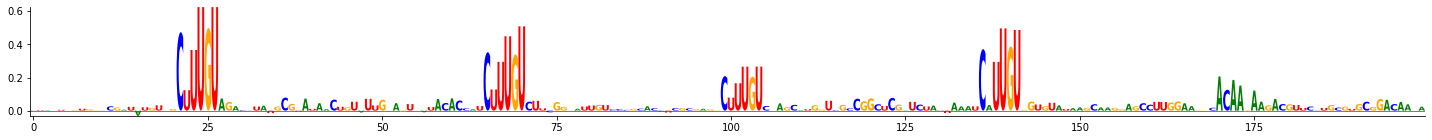

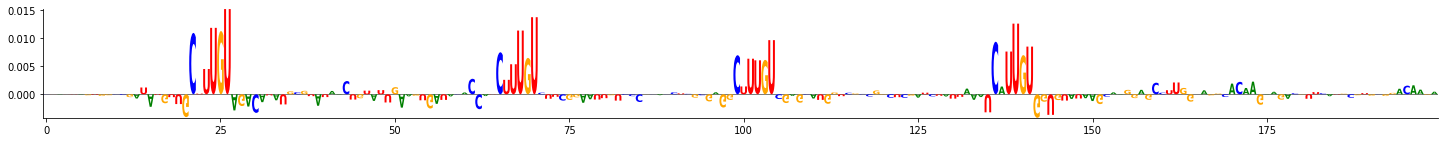

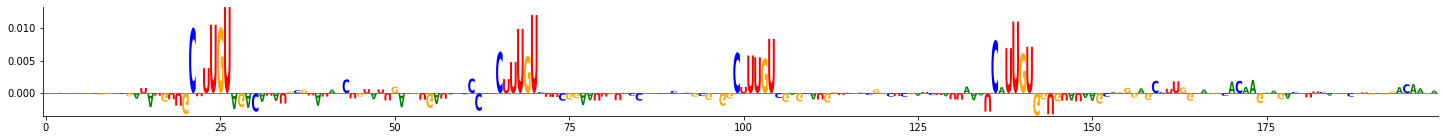

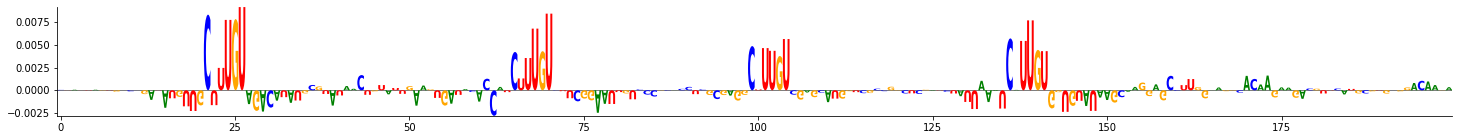

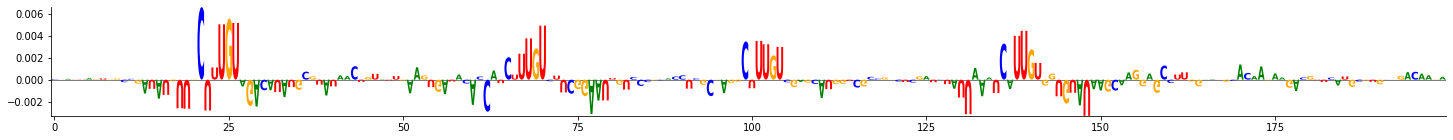

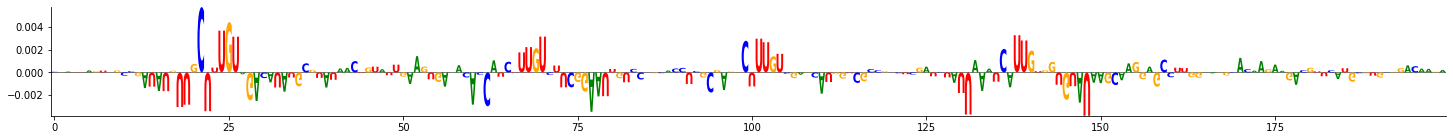

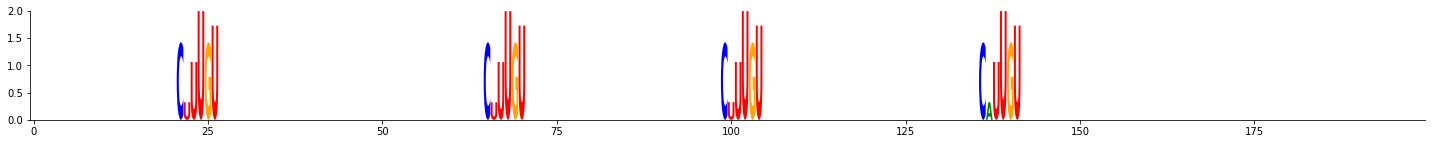

In [ ]:
# PLOT for p=-0.500 parameter 
import logomaker 
s=1 #Pick a sequence 42

N, L, A = attr_score3_AVERAGE.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score3_AVERAGE[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()


N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score6[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()


# PLOT for p=-0.333 parameter 
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score3[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()

# PLOT for p=0 parameter (default classical saliency)
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score1[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05))
    fig = plt.gcf()

# PLOT for p=+0.333 parameter 
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score4[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()

# PLOT for p=+0.500 parameter 
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score5[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()


# PLOT ground truth
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = X_model_normalized[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()

In [ ]:
np.corrcoef(x,y)

array([[ 1.        , -0.95354183],
       [-0.95354183,  1.        ]])

In [ ]:
motif = np.array ([[0,1,0,0],[1,0,0,0],[0,1,0,0], [0,0,1,0],[0,0,0,1],[0,0,1,0]])  #MAX  CACGTG
motif_length = len(motif)
print (motif)


motif_mark = np.zeros(X.shape)
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])-motif_length):
        if (np.sum(X[ii][jj:jj+motif_length] *motif)== motif_length ):  motif_mark[ii][jj:jj+motif_length]=1*X[ii][jj:jj+motif_length]

[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]]


In [ ]:
motif = np.array ([[0,0,0,1],[0,0,0,1],[0,0,1,0], [0,1,0,0],[1,1,1,1],[1,1,1,1],[1,0,0,0],[1,0,0,0]])  #MAX  UUGC_._AA
motif_length = len(motif)
print (motif)


motif_mark = np.zeros(X.shape)
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])-motif_length):
        if (np.sum(X[ii][jj:jj+motif_length] *motif)== motif_length ):  motif_mark[ii][jj:jj+motif_length]=1*X[ii][jj:jj+motif_length]

[[0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 1 1 1]
 [1 1 1 1]
 [1 0 0 0]
 [1 0 0 0]]


In [ ]:
# PLOT for p=-0.500 parameter 
import logomaker 
s=7 #Pick a sequence



# PLOT ground truth
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = X_model_normalized[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()

ModuleNotFoundError: ignored

In [ ]:
print(np.round(saliency_map_raw_AVERAGE[56]*1000),0)

[[  -3.   -2.    1.    2.]
 [   3.   -7.    5.   -3.]
 [   4.   -5.    1.    3.]
 [  -3.    2.    7.    2.]
 [   7.    2.    4.   -6.]
 [  -2.   12.   -4.   -5.]
 [  10.   -0.   -5.   -1.]
 [  -9.  -18.   26.    1.]
 [ -15.    1.   14.   -2.]
 [  11.   -2.   -1.    4.]
 [  23.  -10.   -1.   -7.]
 [  -3.   -2.    7.    2.]
 [  -4.    6.    7.    2.]
 [  -7.    4.   21.   -0.]
 [  10.    3.   12.   -2.]
 [   8.    5.    0.    6.]
 [  -0.  -18.   15.   19.]
 [ -10.   10.    3.    0.]
 [   5.   -4.    4.   15.]
 [   3.    1.   -3.   27.]
 [  -5.   28.  -15.   -3.]
 [  24.   14.   11.  -10.]
 [   2.   15.   52.  -29.]
 [ -61.  170.  -51.  -85.]
 [ 168.  -58.  -66.  -71.]
 [ -24.  160. -156.  -19.]
 [ -28. -166.  154.  -37.]
 [ -38.  -58.  -71.  136.]
 [ -49.  -88.  149.  -61.]
 [ -46.   34.   45.    8.]
 [  -2.    6.    6.   34.]
 [  18.    3.   10.   18.]
 [  -1.    8.   20.   -4.]
 [  10.    5.   -4.   18.]
 [  -4.    8.    6.   15.]
 [   8.   10.    8.   -1.]
 [   1.    8.   13.   -5.]
 

(8813, 2)
0.04991262323456861
(4090, 2)
0.5252996004301025

In [ ]:
print(minimalna_udaljenost)

[0.08084396 0.02003494 1.06412106 ... 0.02518068 0.21537547 0.28356626]


In [ ]:
count=[0]*n_components
for i in range (0, n_components):
    for j in range (0, len(labels)):  
        if (labels[j]==i): count[i]+=1

print(count)


[22, 107, 3, 81]


In [ ]:
z_line = [np.linspace(-1, 1, 5000)]*n_components
x_line = z_line * np.expand_dims( gm.means_[:,0], axis =1)
y_line = z_line * np.expand_dims(gm.means_[:,1], axis=1)

In [ ]:
count=[0]*n_components
distance=[0]*n_components
for i in range (0, n_components):
    for j in range (0, len(labels)):  
        if (labels[j]==i): 
            count[i]+=1
            distance[i]+=np.sqrt(np.sum(np.square(PPP[j,:]-centers[i,:])))
    distance[i]=distance[i]/count[i]
print(count)
print(distance)
print(np.sum(distance))

[22, 107, 3, 81]
[2.436456266313416, 0.2984148424070947, 1.4301684793710008, 0.7028151549872204]
4.867854743078732


In [ ]:
cluster_index = 1
cluster_size = count[cluster_index]
individual_distances_first_cluster = [0]*cluster_size

i=cluster_index
for j in range (0, cluster_size):  
    individual_distances_first_cluster[j]=np.sqrt(np.sum(np.square(PPP[j,:]-centers[i,:])))

print(np.average(np.sort(individual_distances_first_cluster)[0:100]))


0.9041309775259326


In [ ]:
########## Now GGG

Corrected 1st local-exponential: Cluster size je 0.083. Cosine je 0.776.

Corrected 2nd local-exponential: Cluster size je  0.095. je Cosine je 0.776.

Corrected 3rd local-exponential: Cluster size je 0.053. Cosine je 0.798.

Cumulative(first 20)-corr local-exponential: Cluster size je . Cosine je 0.822.

Corrected 1st local-relu: Cluster size je 0.217. Cosine je 0.602. 

Corrected 2nd local-relu: Cluster size je 0.161. Cosine je 0.527.

Corrected 3rd local-relu: Cluster size je 0.312. Cosine je 0.450.

Cummulative (first 20) local-relu: Cluster size je . Cosine je 0.737.

Corrected 1st dist-exponential: Cluster size je 0.033. Cosine je 0.843. 
Corrected 2nd dist-exponential: Cluster size je 0.0288. Cosine je 0.839. 
Corrected 3rd dist-exponential: Cluster size je 0.0488. Cosine je 0.820
Corrected 4th dist-exponential: Cluster size je 0.152. Cosine je 0.622. 
Corrected 5th dist-exponential: Cluster size is 0.904. Cosine je 0.249.
Corrected 20th dist-exponential: Cluster size is 0.0619. Cosine is 0.697.

Corrected 1st dist-relu: Cluster size je 1.289. Cosine je 0.370.

Corrected 2nd dist-relu: Cluster size je 0.354. Cosine je 0.464. 

Corrected 3rd dist-relu: First cluster size is 0.180. Cosine je 0.585. 

Corrected 8th dist-relu: First cluster size is 1.92. Cosine je 0.217. 

Cummulative (20) na dist-relu: First cluster size is . Cosine je 0.655.

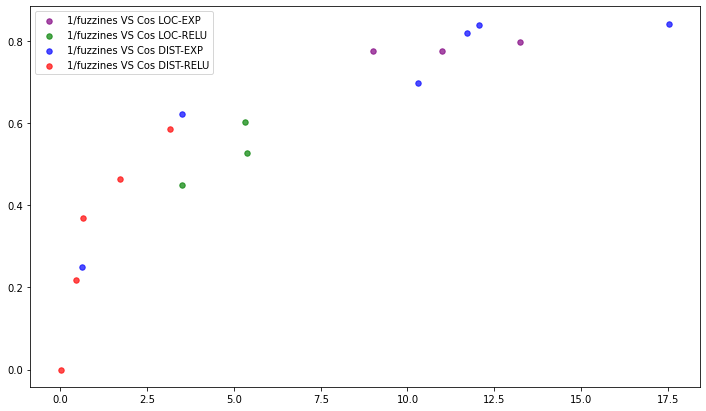

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#xos = [0, 0.56, 0.428, 2.21, 0.865, 0.467, 0.528, 0.528, 3.788]
#xos = [0, 0.122, 0.103, 0.224, 0.192, 0.094, 0.103, 0.223, 0.263, 1.54, 1.58, 0.456]
#yos = [1-1.0, 1-0.822, 1-0.85, 1-0.737, 1-0.697, 1-0.843, 1-0.839, 1-0.82, 1-0.583, 1-0.370, 1-0.464, 1-0.585]

#xos=[0, 0.159, 0.212, 0.081, 0.137, 0.122, 0.420, 1.76, 0.821, 0.456]
#yos=[0, 1-0.602, 1-0.527, 1-0.843, 1-0.839, 1-0.820, 1-0.622, 1-0.370, 1-0.464, 1-0.585]

#Local exponential
xos=2/(np.array([0.099, 0.127, 0.098]) +np.array([0.083, 0.095, 0.053]))
yos=np.array([0.776, 0.776, 0.798]) 
ax1.scatter(np.array(xos), np.array(yos), s=30, c='purple', marker="o", label='1/fuzzines VS Cos LOC-EXP', alpha=0.7)

#Local relu
xos=2/(np.array([0.159, 0.212, 0.258]) + np.array([0.217, 0.161, 0.312]))
yos=np.array([0.602, 0.527, 0.450])
ax1.scatter(np.array(xos), np.array(yos), s=30, c='g', marker="o", label='1/fuzzines VS Cos LOC-RELU', alpha=0.7)

#Dist exponential 
xos=2/(np.array([0.081, 0.137, 0.122, 0.420, 2.25 , 0.132]) + np.array([0.033, 0.0288, 0.0488, 0.152, 0.904, 0.0619]))
yos=np.array([0.843, 0.839, 0.820, 0.622, 0.249, 0.697])
ax1.scatter(np.array(xos), np.array(yos), s=30, c='b', marker="o", label='1/fuzzines VS Cos DIST-EXP', alpha=0.7)

#Dist relu
xos=2/(np.array([1000, 1.76, 0.821, 0.456, 2.69]) + np.array([1000, 1.289, 0.354, 0.180, 1.92]))
yos=np.array([0, 0.370, 0.464, 0.585, 0.217])
ax1.scatter(np.array(xos), np.array(yos), s=30, c='r', marker="o", label='1/fuzzines VS Cos DIST-RELU', alpha=0.7)

#ax1.set_xlim(-0.1,0.6)
#ax1.set_ylim(-0.1,0.6)

plt.legend(loc='upper left');

plt.rcParams['figure.figsize'] = [12, 7]

plt.show()

FUZINNESS ANALYSIS COMPLETE

In [ ]:

############################### NESTO KRIVO


######################################################################## Generate attribution maps
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain


saliencySCAL_print=[]
integratedSCAL_print=[]
mutagenesisSCAL_print=[]
saliency1AUROC_AUPR_print=[]
saliency3AUROC_AUPR_print=[]
integrated1AUROC_AUPR_print=[]
integrated3AUROC_AUPR_print=[]
mutagenesisAUROC_print=[]
mutagenesisAUPR_print=[]
attr_score1_cumulative = []
attr_score3_cumulative = []
saliency_map_raw_cummulative = []
fuzziness = []
L2L2 = []

#------------------------------------------------------------------------

num_trials = 20
model_names = ['cnn-local', 'cnn-dist'] #['cnn-dist', 'cnn-local']
activations = ['exponential', 'relu']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   

#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # interpretability performance with saliency maps
            #print('saliency maps')
            saliency_scores.append(saliency(model, X, class_index=0, layer=-1))

            #interpretability performance with mutagenesis 
            #print('mutagenesis maps')
            #mut_scores.append(mutagenesis(model, X, class_index=0, layer=-1))

            # interpretability performance with integrated gradients
            #print('integrated gradients maps')
            #integrated_scores.append(integrated_grad(model, X, class_index=0, layer=-1,
            #                                            num_background=10, num_steps=20,
            #                                            reference='shuffle'))    #reference='shuffle'

            '''# interpretability performance with deepshap 
            print('shap maps')
            shap_scores.append(deepshap(model, X, class_index=0, 
                                           num_background=10, reference='shuffle'))'''


############ CORRECTION PART , Comparison of attribution maps

            #### Normalized ground truth used for Cosine metric only. (Mapped to interval [0,1]).
            X_model_normalized =  np.swapaxes(X_model, 1,2) *X  * (4 * np.swapaxes(X_model, 1,2) *X -1)/3
            X_model_normalized = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   ) * X  

            #Raw saliency scores.  
            saliency_map_raw = np.array(saliency_scores) [trial]
            #integrated_map_raw = np.array(integrated_scores) [trial]

            #################### Classical saliency map takes only 1 derivative, corresponding to the nucleotide present. 
            attr_score1 = saliency_map_raw * X 

            #Correction for p= -1/3 = -0.333...
            attr_score2 = np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X #
            #Correction is added to the classical result. Final corrected value is stored in attr_score3.
            attr_score3 = attr_score1 +  attr_score2
            

            def Scalar_product(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
                return scalar_product

            def Scalar_product_set(attr_score_copy, X_model_normalized_copy):
                scalar_product = np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  
                return scalar_product    

            print ('-----Saliency cosine:')
            #print (Scalar_product(attr_score1, X_model_normalized))  # Default (p=0)
            print (Scalar_product(attr_score3, X_model_normalized))  # p = -0.333 (correction)

            print ('-----Saliency AUROC:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[0])
            #print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[0])
            print(PrintScreen3)
            #PrintScreen4 = np.average(interpretability_performance(X, attr_score4, X_model)[0])
            #print(PrintScreen4)            

            print ('-----Saliency AUPR:')
            PrintScreen1 = np.average(interpretability_performance(X, attr_score1, X_model)[1])
            #print(PrintScreen1)
            PrintScreen3 = np.average(interpretability_performance(X, attr_score3, X_model)[1])
            print(PrintScreen3)           
            #print('\n')


            saliencySCAL_print.append([Scalar_product(attr_score1, X_model_normalized) , Scalar_product(attr_score3, X_model_normalized)])
            #integratedSCAL_print.append([Scalar_product(attr_score1_integrated, X_model_normalized) , Scalar_product(attr_score3_integrated, X_model_normalized)])
            #mutagenesisSCAL_print.append([Scalar_product(attr_score1_mut, X_model_normalized) , Scalar_product(attr_score3_mut, X_model_normalized)])
            
            saliency1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1, X_model)[0]) , np.average(interpretability_performance(X, attr_score1, X_model)[1]) ])
            #integrated1AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score1_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score1_integrated, X_model)[1]) ])
            saliency3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3, X_model)[0]) , np.average(interpretability_performance(X, attr_score3, X_model)[1]) ])
            #integrated3AUROC_AUPR_print.append([np.average(interpretability_performance(X, attr_score3_integrated, X_model)[0]) , np.average(interpretability_performance(X, attr_score3_integrated, X_model)[1])])

            attr_score1_cumulative.append(attr_score1)
            attr_score3_cumulative.append(attr_score3)
            saliency_map_raw_cummulative.append(saliency_map_raw)




#Apply correction to the whole saliency map 
            saliency_map_raw_CORRECTED = saliency_map_raw - 0.25* np.sum(saliency_map_raw, axis=2, keepdims=True)


#From saliency map to fuzinness: 
##### 2D representation 

# Fixing random state for reproducibility
            np.random.seed(19680801)

            AAA = np.zeros(X.shape)
            CCC = np.zeros(X.shape)
            GGG = np.zeros(X.shape)
            TTT = np.zeros(X.shape)
            for ii in range (0, len(X)):
                for jj in range (0, len(X[0])):
                    AAA[ii][jj][0]=1
                    CCC[ii][jj][1]=1
                    GGG[ii][jj][2]=1
                    TTT[ii][jj][3]=1


            cutooff = 0.5 #0.2

            #xxx_motif=saliency_map_raw_CORRECTED[:,:,0] *np.sign(np.abs(np.sum(motif_mark*X, axis=2, keepdims=True)))[:,:,0]   #saliency_map_raw_AVERAGE_CORRECTED
            #yyy_motif=(saliency_map_raw_CORRECTED[:,:,1]) *np.sign(np.abs(np.sum(motif_mark*X, axis=2, keepdims=True)))[:,:,0]
            #zzz_motif=(saliency_map_raw_CORRECTED[:,:,2]) *np.sign(np.abs(np.sum(motif_mark*X, axis=2, keepdims=True)))[:,:,0]
            xxx_motif=saliency_map_raw_CORRECTED[:,:,0] *np.sign(np.abs(np.sum(X*1, axis=2, keepdims=True)))[:,:,0]   #saliency_map_raw_AVERAGE_CORRECTED
            yyy_motif=(saliency_map_raw_CORRECTED[:,:,1]) *np.sign(np.abs(np.sum(X*1, axis=2, keepdims=True)))[:,:,0]
            zzz_motif=(saliency_map_raw_CORRECTED[:,:,2]) *np.sign(np.abs(np.sum(X*1, axis=2, keepdims=True)))[:,:,0]            
            L2=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)
            L2_cuttof_index = L2 > cutooff
            xxx_motif=xxx_motif[L2_cuttof_index]
            yyy_motif=yyy_motif[L2_cuttof_index]
            zzz_motif=zzz_motif[L2_cuttof_index]
            sample_weight = L2[L2_cuttof_index] 
            x=np.array(xxx_motif)
            y=np.array(yyy_motif)
            z=np.array(zzz_motif)
            x=x/z 
            y=y/z 

            #Filter 
            index=x*x<10  #50
            x=x[index]
            y=y[index]
            sample_weight = sample_weight[index]
            index=y*y<10 #50
            x=x[index]
            y=y[index]
            sample_weight = sample_weight[index]


            #Quick fuzziness estimate:

            fuzzy_sample_size=500
            fuzzy_sample_size = min(fuzzy_sample_size,len(x))
            print(fuzzy_sample_size)

            #All points:
            PPP=np.zeros((len(x),2))
            PPP[:,0]=np.array(x)
            PPP[:,1]=np.array(y)

            #Randomly choose fuzzy_sample_size points to measure distance from:
            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_from = PPP[random_index]
            sample_weight_original=sample_weight
            #sample_weight=np.expand_dims(sample_weight[random_index], axis=1)
            sample_weight=np.array(sample_weight[random_index])

            total_weight = np.sum(sample_weight)
            central_point = np.average(Sample_points_from*np.expand_dims(sample_weight, axis=1), axis=0)/total_weight
            L2_of_the_sample_cloud = np.average( np.sqrt(np.sum(np.square(Sample_points_from-central_point), axis=1)))

            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_to = PPP[random_index]
            sample_weight2=sample_weight_original[random_index]

            distances_list=np.array([])
            for i in range (0, fuzzy_sample_size):
                min_distance = 1000000000
                j_sample=0
                for j in range (0, fuzzy_sample_size):
                    if(np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:]))) < min_distance and np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:]))) > 0 ):
                        min_distance = np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:])))
                        j_sample=j
                distances_list=np.append(distances_list, min_distance)
                sample_weight[i]=1 #sample_weight[i] *sample_weight2[j_sample]
            

            distances_index=np.argsort(distances_list)
            distances_list=distances_list[distances_index]
            sample_weight=sample_weight[distances_index]
            print(distances_list.shape)
            distances_list=distances_list[0:int(fuzzy_sample_size/2)]*sample_weight[0:int(fuzzy_sample_size/2)]
            print(distances_list.shape)
            print(sample_weight.shape)
            distance=np.sum(distances_list)/np.sum(sample_weight[0:int(fuzzy_sample_size/2)])

            fuzziness.append(distance)
            L2L2.append(L2_of_the_sample_cloud)
            print('Fuziness: ', distance)
            print('L2_of_the_sample_cloud: ', L2_of_the_sample_cloud)
            print('')


model: cnn-local_exponential_0
-----Saliency cosine:
0.77626723
-----Saliency AUROC:
0.8645095424831245
-----Saliency AUPR:
0.7722468461342062
371
(371,)
(185,)
(371,)
Fuziness:  0.024214704602735778
L2_of_the_sample_cloud:  1.30395980992853

model: cnn-local_exponential_1
-----Saliency cosine:
0.7761689
-----Saliency AUROC:
0.8614479132599705
-----Saliency AUPR:
0.7741974074284367
439
(439,)
(219,)
(439,)
Fuziness:  0.028255069302819708
L2_of_the_sample_cloud:  1.4214355105455827

model: cnn-local_exponential_2
-----Saliency cosine:
0.79811037
-----Saliency AUROC:
0.8637232782765611
-----Saliency AUPR:
0.7733194485875323
454
(454,)
(227,)
(454,)
Fuziness:  0.01955056750760213
L2_of_the_sample_cloud:  1.2693438599880675

model: cnn-local_exponential_3
-----Saliency cosine:
nan
-----Saliency AUROC:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


0.8646191596606777
-----Saliency AUPR:
0.7689239993835115
500
(500,)
(250,)
(500,)
Fuziness:  0.027110641129689483
L2_of_the_sample_cloud:  1.4857181768544656

model: cnn-local_exponential_4
-----Saliency cosine:
0.76798326
-----Saliency AUROC:
0.8572542169113865
-----Saliency AUPR:
0.768389543300766
330
(330,)
(165,)
(330,)
Fuziness:  0.02749685991166379
L2_of_the_sample_cloud:  1.3644951685039939

model: cnn-local_exponential_5
-----Saliency cosine:
0.7599393
-----Saliency AUROC:
0.8526769946215607
-----Saliency AUPR:
0.7557308681699494
392
(392,)
(196,)
(392,)
Fuziness:  0.030050205984662612
L2_of_the_sample_cloud:  1.3513521015631456

model: cnn-local_exponential_6
-----Saliency cosine:
0.7688307
-----Saliency AUROC:
0.8597662494536837
-----Saliency AUPR:
0.7662842645146399
389
(389,)
(194,)
(389,)
Fuziness:  0.023843974452290247
L2_of_the_sample_cloud:  1.310305522846234

model: cnn-local_exponential_7
-----Saliency cosine:
0.70103097
-----Saliency AUROC:
0.8430830608185679
-----S

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:258: RuntimeWarning: invalid value encountered in double_scalars


model: cnn-dist_exponential_12
-----Saliency cosine:
0.8510791
-----Saliency AUROC:
0.8850413661366693
-----Saliency AUPR:
0.80596682869413
500
(500,)
(250,)
(500,)
Fuziness:  0.014308360640115286
L2_of_the_sample_cloud:  1.3416304957038725

model: cnn-dist_exponential_13
-----Saliency cosine:
0.8340459
-----Saliency AUROC:
0.8859004396197316
-----Saliency AUPR:
0.8059779220965502
500
(500,)
(250,)
(500,)
Fuziness:  0.01567872705281893
L2_of_the_sample_cloud:  1.3687533692422194

model: cnn-dist_exponential_14
-----Saliency cosine:
0.8261969
-----Saliency AUROC:
0.8854411915006967
-----Saliency AUPR:
0.800773122304679
500
(500,)
(250,)
(500,)
Fuziness:  0.014576852171187581
L2_of_the_sample_cloud:  1.2478049508000388

model: cnn-dist_exponential_15
-----Saliency cosine:
0.8380293
-----Saliency AUROC:
0.8875913700414456
-----Saliency AUPR:
0.8056901346751065
500
(500,)
(250,)
(500,)
Fuziness:  0.014848472146004566
L2_of_the_sample_cloud:  1.4429927929517263

model: cnn-dist_exponential_

In [ ]:
print(np.array(attr_score1_cumulative).shape)
saliency3AUROC_AUPR_print_AVERAGE=[]


#############
fuzziness_best_index = np.argsort(fuzziness[40:60])[0:10] + 40
saliency_map_raw_AVERAGE = np.average(np.array(saliency_map_raw_cummulative)[fuzziness_best_index]  , axis = 0)
saliency_map_raw_AVERAGE_CORRECTED = saliency_map_raw_AVERAGE - 0.25* np.sum(saliency_map_raw_AVERAGE, axis=2, keepdims=True)
attr_score1_AVERAGE = np.average(np.array(attr_score1_cumulative)[fuzziness_best_index]  , axis = 0)
attr_score3_AVERAGE = np.average(np.array(attr_score3_cumulative)[fuzziness_best_index]  , axis = 0)
saliency3AUROC_AUPR_print_AVERAGE.append([np.average(interpretability_performance(X, attr_score3_AVERAGE, X_model)[0]) , np.average(interpretability_performance(X, attr_score3_AVERAGE, X_model)[1]) ])

#############

#saliency_map_raw_AVERAGE = np.average(np.array(saliency_map_raw_cummulative[40:60])  , axis = 0)
#saliency_map_raw_AVERAGE_CORRECTED = saliency_map_raw_AVERAGE - 0.25* np.sum(saliency_map_raw_AVERAGE, axis=2, keepdims=True)
#attr_score1_AVERAGE = np.average(np.array(attr_score1_cumulative[40:60])  , axis = 0)
#attr_score3_AVERAGE = np.average(np.array(attr_score3_cumulative[40:60])  , axis = 0)
#saliency3AUROC_AUPR_print_AVERAGE.append([np.average(interpretability_performance(X, attr_score3_AVERAGE, X_model)[0]) , np.average(interpretability_performance(X, attr_score3_AVERAGE, X_model)[1]) ])



fuzziness_AVERAGE = []
L2L2 = []


for ijk in range (0,1):
    for ijkl in range (0,1):   
# Fixing random state for reproducibility
        for dhdh in range (0,1): 
            np.random.seed(19680801)

            AAA = np.zeros(X.shape)
            CCC = np.zeros(X.shape)
            GGG = np.zeros(X.shape)
            TTT = np.zeros(X.shape)
            for ii in range (0, len(X)):
                for jj in range (0, len(X[0])):
                    AAA[ii][jj][0]=1
                    CCC[ii][jj][1]=1
                    GGG[ii][jj][2]=1
                    TTT[ii][jj][3]=1


            cutooff = 0.5 #0.5 

            #xxx_motif=saliency_map_raw_CORRECTED[:,:,0] *np.sign(np.abs(np.sum(motif_mark*X, axis=2, keepdims=True)))[:,:,0]   #saliency_map_raw_AVERAGE_CORRECTED
            #yyy_motif=(saliency_map_raw_CORRECTED[:,:,1]) *np.sign(np.abs(np.sum(motif_mark*X, axis=2, keepdims=True)))[:,:,0]
            #zzz_motif=(saliency_map_raw_CORRECTED[:,:,2]) *np.sign(np.abs(np.sum(motif_mark*X, axis=2, keepdims=True)))[:,:,0]
            xxx_motif=saliency_map_raw_AVERAGE_CORRECTED[:,:,0] *np.sign(np.abs(np.sum(X*1, axis=2, keepdims=True)))[:,:,0]   #saliency_map_raw_AVERAGE_CORRECTED
            yyy_motif=(saliency_map_raw_AVERAGE_CORRECTED[:,:,1]) *np.sign(np.abs(np.sum(X*1, axis=2, keepdims=True)))[:,:,0]
            zzz_motif=(saliency_map_raw_AVERAGE_CORRECTED[:,:,2]) *np.sign(np.abs(np.sum(X*1, axis=2, keepdims=True)))[:,:,0]            
            L2=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)
            L2_cuttof_index = L2 > cutooff
            xxx_motif=xxx_motif[L2_cuttof_index]
            yyy_motif=yyy_motif[L2_cuttof_index]
            zzz_motif=zzz_motif[L2_cuttof_index]
            sample_weight = L2[L2_cuttof_index] 
            x=np.array(xxx_motif)
            y=np.array(yyy_motif)
            z=np.array(zzz_motif)
            x=x/z 
            y=y/z 

            #Filter 
            index=x*x<10  #50
            x=x[index]
            y=y[index]
            sample_weight = sample_weight[index]
            index=y*y<10 #50
            x=x[index]
            y=y[index]
            sample_weight = sample_weight[index]


            #Quick fuzziness estimate:

            fuzzy_sample_size=500
            fuzzy_sample_size = min(fuzzy_sample_size,len(x))
            print(fuzzy_sample_size)

            #All points:
            PPP=np.zeros((len(x),2))
            PPP[:,0]=np.array(x)
            PPP[:,1]=np.array(y)

            #Randomly choose fuzzy_sample_size points to measure distance from:
            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_from = PPP[random_index]
            sample_weight_original=sample_weight
            #sample_weight=np.expand_dims(sample_weight[random_index], axis=1)
            sample_weight=np.array(sample_weight[random_index])

            total_weight = np.sum(sample_weight)
            central_point = np.average(Sample_points_from*np.expand_dims(sample_weight, axis=1), axis=0)/total_weight
            L2_of_the_sample_cloud = np.average( np.sqrt(np.sum(np.square(Sample_points_from-central_point), axis=1)))

            random_index = (np.random.rand(fuzzy_sample_size)*len(PPP)).astype(int)
            Sample_points_to = PPP[random_index]
            sample_weight2=sample_weight_original[random_index]

            distances_list=np.array([])
            for i in range (0, fuzzy_sample_size):
                min_distance = 1000000000
                j_sample=0
                for j in range (0, fuzzy_sample_size):
                    if(np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:]))) < min_distance and np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:]))) > 0 ):
                        min_distance = np.sqrt(np.sum(np.square(Sample_points_from[i,:]-Sample_points_to[j,:])))
                        j_sample=j
                distances_list=np.append(distances_list, min_distance)
                sample_weight[i]= 1# sample_weight[i] *sample_weight2[j_sample]
            

            distances_index=np.argsort(distances_list)
            distances_list=distances_list[distances_index]
            sample_weight=sample_weight[distances_index]
            print(distances_list.shape)
            distances_list=distances_list[0:int(fuzzy_sample_size/2)]*sample_weight[0:int(fuzzy_sample_size/2)]
            print(distances_list.shape)
            print(sample_weight.shape)
            distance=np.sum(distances_list)/np.sum(sample_weight[0:int(fuzzy_sample_size/2)])

            fuzziness_AVERAGE.append(distance)
            L2L2.append(L2_of_the_sample_cloud)
            print('Fuziness: ', distance)
            print('L2_of_the_sample_cloud: ', L2_of_the_sample_cloud)
            print('')




(80, 500, 200, 4)
500
(500,)
(250,)
(500,)
Fuziness:  0.008792293330411174
L2_of_the_sample_cloud:  1.5813978195874479



In [ ]:
#fuzziness_AVERAGE1=fuzziness_AVERAGE
#saliency3AUROC_AUPR_print_AVERAGE1= saliency3AUROC_AUPR_print_AVERAGE

#fuzziness_AVERAGE2=fuzziness_AVERAGE
#saliency3AUROC_AUPR_print_AVERAGE2= saliency3AUROC_AUPR_print_AVERAGE

#fuzziness_AVERAGE3=fuzziness_AVERAGE
#saliency3AUROC_AUPR_print_AVERAGE3= saliency3AUROC_AUPR_print_AVERAGE

fuzziness_AVERAGE3_best=fuzziness_AVERAGE
saliency3AUROC_AUPR_print_AVERAGE3_best= saliency3AUROC_AUPR_print_AVERAGE

#fuzziness_AVERAGE4=fuzziness_AVERAGE
#saliency3AUROC_AUPR_print_AVERAGE4= saliency3AUROC_AUPR_print_AVERAGE

In [ ]:
print(sample_weight[0:20])
print(sample_weight2[0:100])

[0.01873071 0.29728612 0.29728612 0.29728612 0.02835846 0.02766475
 0.03592709 0.01981576 0.03025849 0.01857276 0.02911565 0.02911565
 0.01550991 0.01806548 0.01806548 0.01806548 0.01971967 0.02466037
 0.02056704 0.01676566]
[0.15687644 0.14080589 0.18970145 0.11863538 0.16672973 0.15344608
 0.1270117  0.15112023 0.11636259 0.18142413 0.1423919  0.18928887
 0.109312   0.15623002 0.15826507 0.11246052 0.12352683 0.13142307
 0.11215933 0.10206687 0.12171073 0.19073124 0.308253   0.12553695
 0.17569642 0.2433988  0.10441099 0.13380454 0.22596928 0.22909313
 0.10484688 0.18107365 0.1557364  0.19089633 0.19345455 0.81213766
 0.17421234 0.15567656 0.26281455 0.2467444  0.10248103 0.12844032
 0.14205572 0.19324727 0.11907801 0.21387939 0.2669018  0.14911644
 0.15430455 0.11836208 0.11980232 0.15562947 0.10254345 0.45057553
 0.12261756 0.16414951 0.10611452 0.42277774 0.24785323 0.17037268
 0.11534993 0.15623002 0.11191112 0.14461645 0.2885555  0.11194445
 0.13534695 0.14687508 0.15891713 0.11

In [ ]:
print(distances_list[0:20])
print(distances_list.shape)
print(min_distance)
print(distances_index.shape)

[0.00082311 0.00716357 0.00716357 0.00716357 0.00716682 0.00739757
 0.00824351 0.00870903 0.00883623 0.00960773 0.01075146 0.01075146
 0.01349251 0.01370445 0.01370445 0.01370445 0.01409712 0.0151755
 0.01611554 0.01651117]
(250,)
0.15397741053536268
(500,)


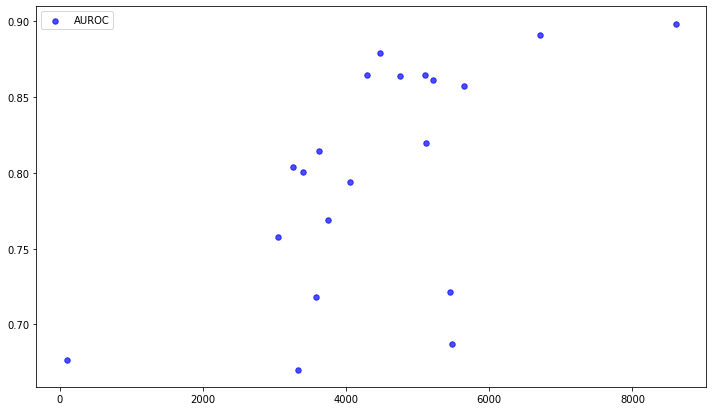

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.log(1/np.array(fuzziness)), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness)/np.array(L2L2)), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='r', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(1/np.array(L2L2), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='g', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(1/np.array(fuzziness), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(1/np.array(fuzziness)/np.array(L2L2), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='r', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(1/np.array(L2L2), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='g', marker="o", label='AUROC', alpha=0.7)


#ax1.scatter(np.log(1/np.array(fuzziness))[0:20], np.array(saliency3AUROC_AUPR_print)[0:20,0], s=30, c='b', marker="o", label='local exp', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness))[20:40], np.array(saliency3AUROC_AUPR_print)[20:40,0], s=30, c='r', marker="o", label='local relu', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness))[40:60], np.array(saliency3AUROC_AUPR_print)[40:60,0], s=30, c='g', marker="o", label='dist exp', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness))[60:80], np.array(saliency3AUROC_AUPR_print)[60:80,0], s=30, c='orange', marker="o", label='dist relu', alpha=0.7)


ax1.scatter(1/np.array(fuzziness), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness)/np.array(L2L2)), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='r', marker="o", label='AUROC', alpha=0.7)



lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]



plt.rcParams['figure.figsize'] = [12, 7]

plt.legend(loc='upper left');
plt.show()

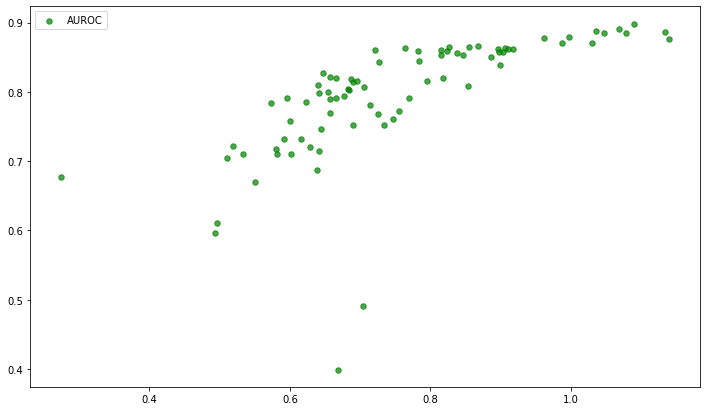

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)


#ax1.scatter(1/np.array(fuzziness), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness)/np.array(L2L2)), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='r', marker="o", label='AUROC', alpha=0.7)
ax1.scatter(1/np.array(L2L2), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='g', marker="o", label='AUROC', alpha=0.7)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.legend(loc='upper left');
plt.show()

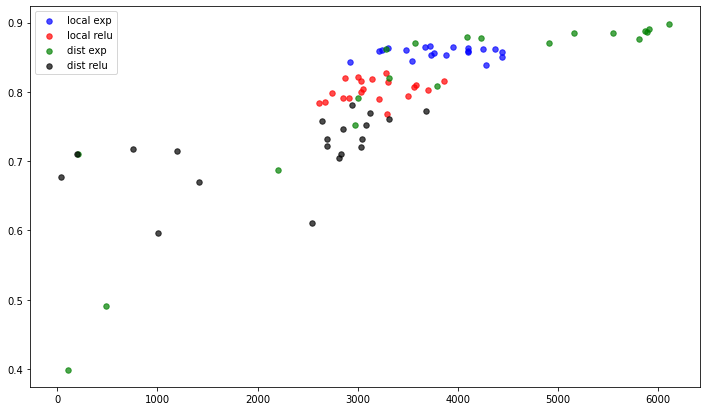

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)


#ax1.scatter(1/np.array(fuzziness), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness)/np.array(L2L2)), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='r', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(1/np.array(L2L2), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='g', marker="o", label='AUROC', alpha=0.7)

ax1.scatter((1/np.array(fuzziness))[0:20], np.array(saliency3AUROC_AUPR_print)[0:20,0], s=30, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter((1/np.array(fuzziness))[20:40], np.array(saliency3AUROC_AUPR_print)[20:40,0], s=30, c='r', marker="o", label='local relu', alpha=0.7)
ax1.scatter((1/np.array(fuzziness))[40:60], np.array(saliency3AUROC_AUPR_print)[40:60,0], s=30, c='g', marker="o", label='dist exp', alpha=0.7)
ax1.scatter((1/np.array(fuzziness))[60:80], np.array(saliency3AUROC_AUPR_print)[60:80,0], s=30, c='black', marker="o", label='dist relu', alpha=0.7)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.legend(loc='upper left');
plt.show()

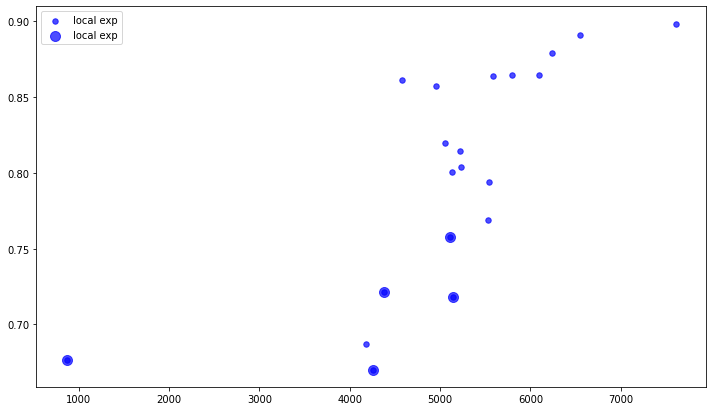

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)


#ax1.scatter(1/np.array(fuzziness), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness)/np.array(L2L2)), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='r', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(1/np.array(L2L2), np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='g', marker="o", label='AUROC', alpha=0.7)

ax1.scatter((1/np.array(fuzziness))[0:20], np.array(saliency3AUROC_AUPR_print)[0:20,0], s=30, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter((1/np.array(fuzziness))[15:20], np.array(saliency3AUROC_AUPR_print)[15:20,0], s=100, c='b', marker="o", label='local exp', alpha=0.7)
#ax1.scatter((1/np.array(fuzziness))[20:40], np.array(saliency3AUROC_AUPR_print)[20:40,0], s=30, c='r', marker="o", label='local relu', alpha=0.7)
#ax1.scatter((1/np.array(fuzziness))[40:60], np.array(saliency3AUROC_AUPR_print)[40:60,0], s=30, c='g', marker="o", label='dist exp', alpha=0.7)
#ax1.scatter((1/np.array(fuzziness))[60:80], np.array(saliency3AUROC_AUPR_print)[60:80,0], s=30, c='black', marker="o", label='dist relu', alpha=0.7)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.legend(loc='upper left');
plt.show()

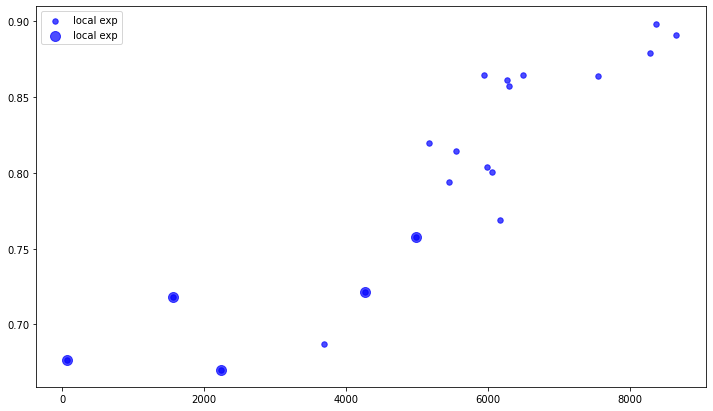

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter((1/np.array(fuzziness))[0:20], np.array(saliency3AUROC_AUPR_print)[0:20,0], s=30, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter((1/np.array(fuzziness))[15:20], np.array(saliency3AUROC_AUPR_print)[15:20,0], s=100, c='b', marker="o", label='local exp', alpha=0.7)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.legend(loc='upper left');
plt.show()

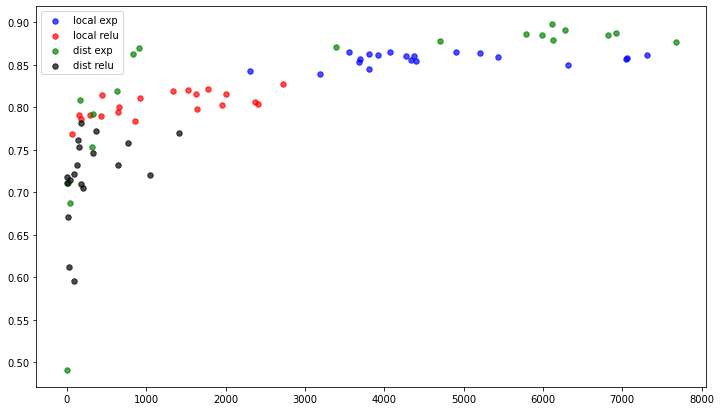

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter((1/np.array(fuzziness)/np.array(L2L2))[0:20], np.array(saliency3AUROC_AUPR_print)[0:20,0], s=30, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter((1/np.array(fuzziness)/np.array(L2L2))[20:40], np.array(saliency3AUROC_AUPR_print)[20:40,0], s=30, c='r', marker="o", label='local relu', alpha=0.7)
ax1.scatter((1/np.array(fuzziness)/np.array(L2L2))[40:60], np.array(saliency3AUROC_AUPR_print)[40:60,0], s=30, c='g', marker="o", label='dist exp', alpha=0.7)
ax1.scatter((1/np.array(fuzziness)/np.array(L2L2))[60:80], np.array(saliency3AUROC_AUPR_print)[60:80,0], s=30, c='black', marker="o", label='dist relu', alpha=0.7)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.legend(loc='upper left');
plt.show()

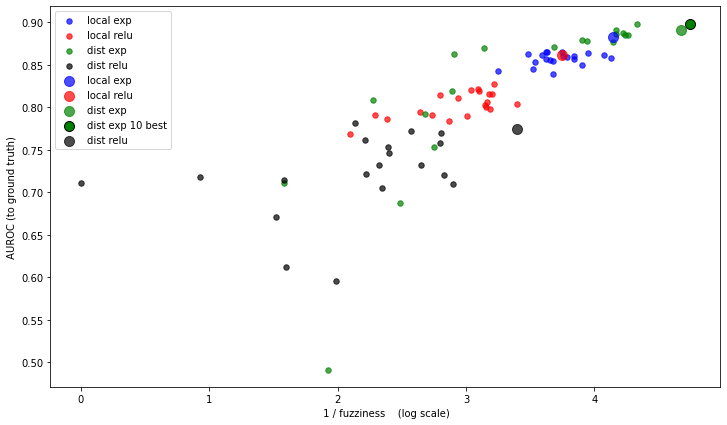

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.log(1/np.array(fuzziness)+1)[0:20], np.array(saliency3AUROC_AUPR_print)[0:20,0], s=30, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[20:40], np.array(saliency3AUROC_AUPR_print)[20:40,0], s=30, c='r', marker="o", label='local relu', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[40:60], np.array(saliency3AUROC_AUPR_print)[40:60,0], s=30, c='g', marker="o", label='dist exp', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[60:80], np.array(saliency3AUROC_AUPR_print)[60:80,0], s=30, c='black', marker="o", label='dist relu', alpha=0.7)

ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE1)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE1)[0:20,0], s=100, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE2)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE2)[0:20,0], s=100, c='r', marker="o", label='local relu', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE3)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE3)[0:20,0], s=100, c='g', marker="o", label='dist exp', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE3_best)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE3_best)[0:20,0], s=100, c='g', marker="o", label='dist exp 10 best', alpha=1, edgecolor='black', linewidth=1)
ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE4)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE4)[0:20,0], s=100, c='black', marker="o", label='dist relu', alpha=0.7)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.xlabel(' 1 / fuzziness    (log scale)')
plt.ylabel(' AUROC (to ground truth) ')

plt.legend(loc='upper left');
plt.show()

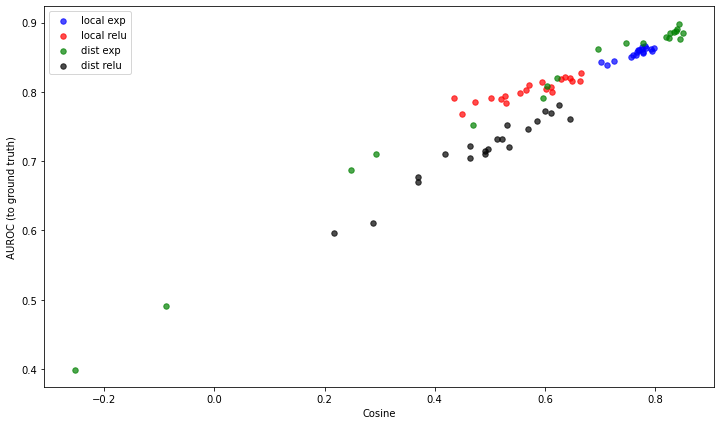

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.array(saliencySCAL_print)[0:20,1], np.array(saliency3AUROC_AUPR_print)[0:20,0], s=30, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter(np.array(saliencySCAL_print)[20:40,1], np.array(saliency3AUROC_AUPR_print)[20:40,0], s=30, c='r', marker="o", label='local relu', alpha=0.7)
ax1.scatter(np.array(saliencySCAL_print)[40:60,1], np.array(saliency3AUROC_AUPR_print)[40:60,0], s=30, c='g', marker="o", label='dist exp', alpha=0.7)
ax1.scatter(np.array(saliencySCAL_print)[60:80,1], np.array(saliency3AUROC_AUPR_print)[60:80,0], s=30, c='black', marker="o", label='dist relu', alpha=0.7)

#ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE1)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE1)[0:20,0], s=100, c='b', marker="o", label='local exp', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE1)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE1)[0:20,0], s=100, c='r', marker="o", label='local exp', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE3)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE3)[0:20,0], s=100, c='g', marker="o", label='local exp', alpha=0.7)
#ax1.scatter(np.log(1/np.array(fuzziness_AVERAGE4)+1)[0:20], np.array(saliency3AUROC_AUPR_print_AVERAGE4)[0:20,0], s=100, c='black', marker="o", label='local exp', alpha=0.7)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.xlabel('Cosine')
plt.ylabel(' AUROC (to ground truth) ')

plt.legend(loc='upper left');
plt.show()

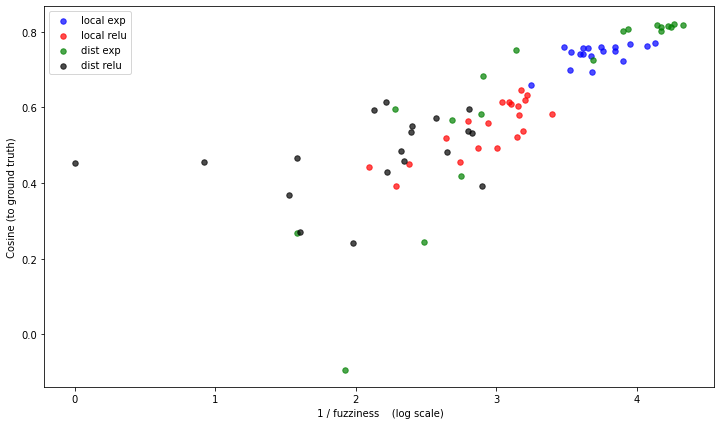

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.log(1/np.array(fuzziness)+1)[0:20], np.array(saliencySCAL_print)[0:20,0], s=30, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[20:40], np.array(saliencySCAL_print)[20:40,0], s=30, c='r', marker="o", label='local relu', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[40:60], np.array(saliencySCAL_print)[40:60,0], s=30, c='g', marker="o", label='dist exp', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[60:80], np.array(saliencySCAL_print)[60:80,0], s=30, c='black', marker="o", label='dist relu', alpha=0.7)


lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.xlabel(' 1 / fuzziness    (log scale)')
plt.ylabel(' Cosine (to ground truth) ')

plt.legend(loc='upper left');
plt.show()

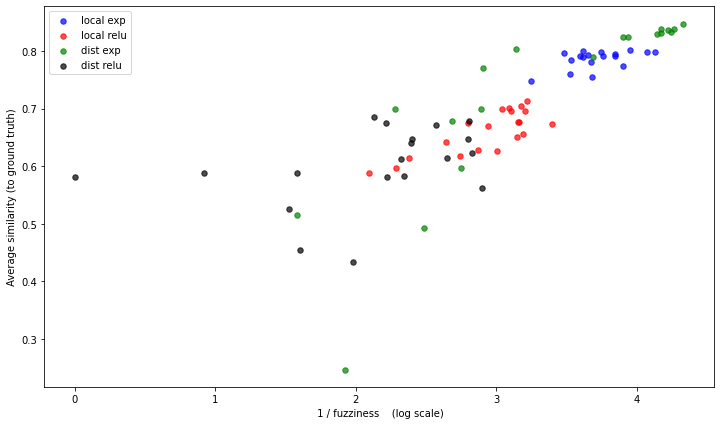

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.log(1/np.array(fuzziness)+1)[0:20], 1/3*np.array(saliencySCAL_print)[0:20,0]+1/3*np.array(saliency3AUROC_AUPR_print)[0:20,0]+1/3*np.array(saliency3AUROC_AUPR_print)[0:20,1], s=30, c='b', marker="o", label='local exp', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[20:40], 1/3*np.array(saliencySCAL_print)[20:40,0]+1/3*np.array(saliency3AUROC_AUPR_print)[20:40,0]+1/3*np.array(saliency3AUROC_AUPR_print)[20:40,1], s=30, c='r', marker="o", label='local relu', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[40:60], 1/3*np.array(saliencySCAL_print)[40:60,0]+1/3*np.array(saliency3AUROC_AUPR_print)[40:60,0]+1/3*np.array(saliency3AUROC_AUPR_print)[40:60,1], s=30, c='g', marker="o", label='dist exp', alpha=0.7)
ax1.scatter(np.log(1/np.array(fuzziness)+1)[60:80], 1/3*np.array(saliencySCAL_print)[60:80,0]+1/3*np.array(saliency3AUROC_AUPR_print)[60:80,0]+1/3*np.array(saliency3AUROC_AUPR_print)[60:80,1], s=30, c='black', marker="o", label='dist relu', alpha=0.7)


lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.xlabel(' 1 / fuzziness    (log scale)')
plt.ylabel(' Average similarity (to ground truth) ')

plt.legend(loc='upper left');
plt.show()

No handles with labels found to put in legend.


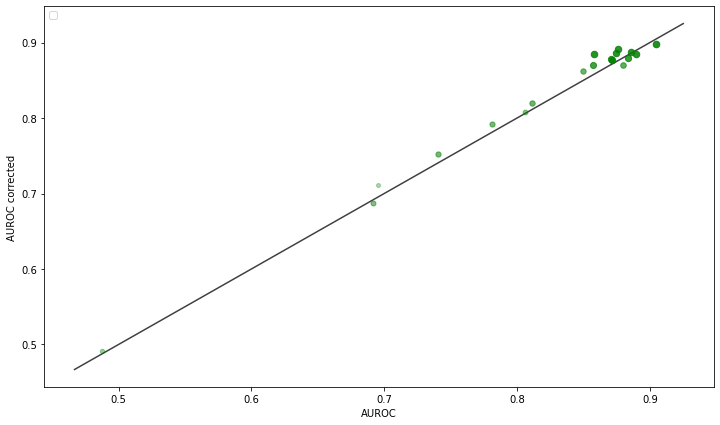

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

'''for j, s in enumerate (np.log(1/np.array(fuzziness)+1)[0:20]):
    ax1.scatter(np.array(saliency1AUROC_AUPR_print)[j,0], np.array(saliency3AUROC_AUPR_print)[j,0], s*10, c='b', marker="o", alpha=0.2*s)

for j, s in enumerate (np.log(1/np.array(fuzziness)+1)[20:40]):
    ax1.scatter(np.array(saliency1AUROC_AUPR_print)[20+j,0], np.array(saliency3AUROC_AUPR_print)[20+j,0], s*10, c='r', marker="o", alpha=0.2*s)
'''
for j, s in enumerate (np.log(1/np.array(fuzziness)+1)[40:60]):
    ax1.scatter(np.array(saliency1AUROC_AUPR_print)[40+j,0], np.array(saliency3AUROC_AUPR_print)[40+j,0], s*10, c='g', marker="o", alpha=0.2*s)

#for j, s in enumerate (np.log(1/np.array(fuzziness)+1)[60:80]):
#    ax1.scatter(np.array(saliency1AUROC_AUPR_print)[60+j,0], np.array(saliency3AUROC_AUPR_print)[60+j,0], s*10, c='black', marker="o", alpha=0.2*s)

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

plt.rcParams['figure.figsize'] = [12, 7]

plt.xlabel('AUROC')
plt.ylabel('AUROC corrected')

ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.legend(loc='upper left');
plt.show()

ANGLE STATISTICAL ANALYSIS

In [ ]:
###  Angle histograms


######################################################################## Generate attribution maps
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain

def Scalar_product(attr_score_copy, X_model_normalized_copy):
	scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
	return scalar_product

saliencySCAL_print=[]
integratedSCAL_print=[]
mutagenesisSCAL_print=[]
saliency1AUROC_AUPR_print=[]
saliency3AUROC_AUPR_print=[]
integrated1AUROC_AUPR_print=[]
integrated3AUROC_AUPR_print=[]
mutagenesisAUROC_print=[]
mutagenesisAUPR_print=[]
attr_score1_cumulative = []
attr_score3_cumulative = []
saliency_map_raw_cummulative = []
fuzziness = []
L2L2 = []

#------------------------------------------------------------------------

num_trials = 50
model_names = ['cnn-local'] #['cnn-dist', 'cnn-local']
activations = ['exponential']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'   #6
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   


AAA = np.zeros(X.shape)
CCC = np.zeros(X.shape)
GGG = np.zeros(X.shape)
TTT = np.zeros(X.shape)
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])):
        AAA[ii][jj][0]=1
        CCC[ii][jj][1]=1
        GGG[ii][jj][2]=1
        TTT[ii][jj][3]=1


#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # interpretability performance with saliency maps
            saliency_scores.append(saliency(model, X, class_index=0, layer=-1))



############ CORRECTION PART , Comparison of attribution maps

            #### Normalized ground truth used for Cosine metric only. (Mapped to interval [0,1]).
            X_model_normalized =  np.swapaxes(X_model, 1,2) *X  * (4 * np.swapaxes(X_model, 1,2) *X -1)/3
            X_model_normalized = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   ) * X  

            #Raw saliency scores.  
            saliency_map_raw = np.array(saliency_scores) [trial]


            #################### Classical saliency map takes only 1 derivative, corresponding to the nucleotide present. 
            attr_score1 = saliency_map_raw * X 

            #Correction for p= -1/3 = -0.333...
            attr_score2 = np.sum(saliency_map_raw * (X -1)*(X-1) , axis=2, keepdims=True) *(-0.333)  * X 
            #Correction is added to the classical result. Final corrected value is stored in attr_score3.
            attr_score3 = attr_score1 +  attr_score2
            

            saliency_map_raw_cummulative.append(saliency_map_raw)
            
            print ('-----Saliency cosine:')
            print (Scalar_product(attr_score1, X_model_normalized))  # Default (p=0)
            print (Scalar_product(attr_score3, X_model_normalized)) 


model: cnn-local_exponential_0
-----Saliency cosine:
0.5320713
0.5823052
model: cnn-local_exponential_1
-----Saliency cosine:
0.74895424
0.7636205
model: cnn-local_exponential_2
-----Saliency cosine:
0.7790511
0.80310494
model: cnn-local_exponential_3
-----Saliency cosine:
0.7842392
0.8132344
model: cnn-local_exponential_4
-----Saliency cosine:
0.6778478
0.69184095
model: cnn-local_exponential_5
-----Saliency cosine:
0.76445913
0.79008687
model: cnn-local_exponential_6
-----Saliency cosine:
0.7304053
0.75337905
model: cnn-local_exponential_7
-----Saliency cosine:
0.6628383
0.67809314
model: cnn-local_exponential_8
-----Saliency cosine:
0.7731483
0.79187363
model: cnn-local_exponential_9
-----Saliency cosine:
0.6305372
0.65271175
model: cnn-local_exponential_10
-----Saliency cosine:
0.72340506
0.7476774
model: cnn-local_exponential_11
-----Saliency cosine:
0.63126695
0.66574943
model: cnn-local_exponential_12
-----Saliency cosine:
0.76272005
0.7814435
model: cnn-local_exponential_13
---

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


model: cnn-local_exponential_32
-----Saliency cosine:
0.72442126
0.7578158
model: cnn-local_exponential_33
-----Saliency cosine:
0.77370876
0.79661804
model: cnn-local_exponential_34
-----Saliency cosine:
0.74041414
0.7672008
model: cnn-local_exponential_35
-----Saliency cosine:
0.779423
0.7999433
model: cnn-local_exponential_36
-----Saliency cosine:
0.71482253
0.7364507
model: cnn-local_exponential_37
-----Saliency cosine:
0.76972026
0.7902654
model: cnn-local_exponential_38
-----Saliency cosine:
0.7122799
0.7226022
model: cnn-local_exponential_39
-----Saliency cosine:
0.6973158
0.72952986
model: cnn-local_exponential_40
-----Saliency cosine:
0.6972081
0.7264172
model: cnn-local_exponential_41
-----Saliency cosine:
0.73388445
0.7635648
model: cnn-local_exponential_42
-----Saliency cosine:
0.70454115
0.73081994
model: cnn-local_exponential_43
-----Saliency cosine:
0.753721
0.7831048
model: cnn-local_exponential_44
-----Saliency cosine:
0.70781237
0.7430646
model: cnn-local_exponential_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


[-0.0001582   0.00155192  0.00059909 -0.00142611]
[-0.03967273 -0.01174545  0.10636362 -0.05494545]


(array([9.000e+00, 3.300e+01, 8.600e+01, 1.210e+02, 1.670e+02, 2.400e+02,
        3.340e+02, 4.520e+02, 6.670e+02, 8.610e+02, 9.100e+02, 8.030e+02,
        7.500e+02, 6.520e+02, 6.200e+02, 7.040e+02, 7.090e+02, 8.090e+02,
        8.380e+02, 8.680e+02, 9.310e+02, 9.850e+02, 1.023e+03, 1.035e+03,
        1.155e+03, 1.210e+03, 1.300e+03, 1.447e+03, 1.538e+03, 1.752e+03,
        1.827e+03, 1.988e+03, 2.163e+03, 2.432e+03, 2.410e+03, 2.586e+03,
        2.589e+03, 2.833e+03, 2.839e+03, 2.887e+03, 2.997e+03, 2.889e+03,
        2.827e+03, 2.736e+03, 2.745e+03, 2.571e+03, 2.481e+03, 2.360e+03,
        2.291e+03, 2.099e+03, 2.074e+03, 1.856e+03, 1.704e+03, 1.680e+03,
        1.607e+03, 1.460e+03, 1.386e+03, 1.264e+03, 1.226e+03, 1.158e+03,
        1.000e+03, 1.015e+03, 9.820e+02, 8.250e+02, 7.660e+02, 6.940e+02,
        6.240e+02, 5.980e+02, 4.890e+02, 4.760e+02, 4.200e+02, 3.570e+02,
        3.580e+02, 3.280e+02, 2.520e+02, 2.270e+02, 2.380e+02, 1.840e+02,
        1.870e+02, 1.500e+02, 1.150e+0

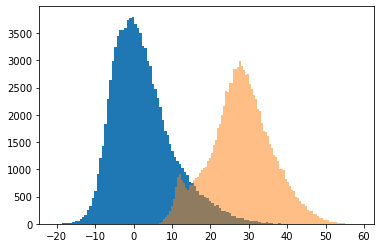

In [ ]:
saliency_map_raw_cummulative=np.array(saliency_map_raw_cummulative)

orthogonal_residual=(saliency_map_raw_cummulative[:,:,:,0]+saliency_map_raw_cummulative[:,:,:,1]+saliency_map_raw_cummulative[:,:,:,2]+saliency_map_raw_cummulative[:,:,:,3]) 
L2 = np.sqrt(np.sum(np.square(saliency_map_raw_cummulative[:,:,:,:]), axis=3))
sine = 1/2 * orthogonal_residual /L2 
sine = np.arcsin(sine) * 180 /( 3.1416) 

sine_mu = np.average(sine, axis=0)
sine_std = np.std(sine, axis=0)
sine_mu =np.array(sine_mu.reshape(len(sine_mu)*len(sine_mu[0]),))
sine_std =np.array(sine_std.reshape(len(sine_std)*len(sine_std[0]),))

#X_model_normalized_no_multipy_with_X = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   )
X_model_mistery =  np.swapaxes(X_model, 1,2) -0.25
X_model_normalized_50 = []
for i in range (0,len(saliency_map_raw_cummulative)):
    X_model_normalized_50.append(X_model_mistery)   
X_model_normalized_50=np.array(X_model_normalized_50)    

#Improvement
saliency_map_raw_cummulative_CORRECTED = saliency_map_raw_cummulative - 0.25* np.sum(saliency_map_raw_cummulative, axis=3, keepdims=True) 
similarity1= np.sum(saliency_map_raw_cummulative * X_model_normalized_50, axis=3) / ( np.sqrt(np.sum(saliency_map_raw_cummulative*saliency_map_raw_cummulative, axis=3))  *  np.sqrt(np.sum(X_model_normalized_50*X_model_normalized_50, axis=3)) )
similarity3= np.sum(saliency_map_raw_cummulative_CORRECTED * X_model_normalized_50, axis=3) / ( np.sqrt(np.sum(saliency_map_raw_cummulative_CORRECTED*saliency_map_raw_cummulative_CORRECTED, axis=3))  *  np.sqrt(np.sum(X_model_normalized_50*X_model_normalized_50, axis=3)) )
improvement = similarity3 - similarity1

#Saliency_Peter:
saliency_Peter1= np.sum(saliency_map_raw_cummulative * X, axis=3)
saliency_Peter3= np.sum(saliency_map_raw_cummulative_CORRECTED * X, axis=3)

#similarity1[7,100,41]
print(saliency_map_raw_cummulative[7,100,41])
print(X_model_normalized_50[7,100,41])

plt.hist(sine_mu, 100)
plt.hist(sine_std, 100, alpha=0.5)
#plt.yscale('log')

In [ ]:
print(saliency_map_raw_cummulative.shape)
print(X_model_normalized_50.shape)
print(improvement.shape)
print(sine.shape)
print(saliency_Peter3.shape)
print(np.max(np.nan_to_num(similarity1)))
print(similarity1[7,100,47:50])
print(X_model_normalized_50[7,100,47])
print(saliency_map_raw_cummulative[7,100,47])
print(saliency_map_raw_cummulative_CORRECTED[7,100,47])
print(saliency_Peter1.shape)
print(similarity1[7,100,30:60])
print(improvement[7,100,30:60])

(50, 500, 200, 4)
(50, 500, 200, 4)
(50, 500, 200)
(50, 500, 200)
(50, 500, 200)
0.9999581
[0.9825226 0.8436903 0.8891361]
[-0.25       -0.25        0.7443601  -0.24436009]
[-0.00100608 -0.00143266  0.00369303 -0.00203701]
[-0.0008104  -0.00123698  0.00388871 -0.00184133]
(50, 500, 200)
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.2253252  0.46764
 0.85953856 0.95874554 0.67948836 0.8139671  0.98486143 0.9825226
 0.8436903  0.8891361         nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
[          nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
 1.4492369e-01 3.9390028e-03 1.2620747e-02 3.7888765e-02 6.2886715e-02
 2.6050568e-02 2.0917058e-03 3.6285520e-03 2.9043674e-02 1.1920929e-07
           nan           nan           nan           nan           nan
           nan           

In [ ]:
np.average(np.nan_to_num(improvement))

0.009661899

(-0.75, 1.0)

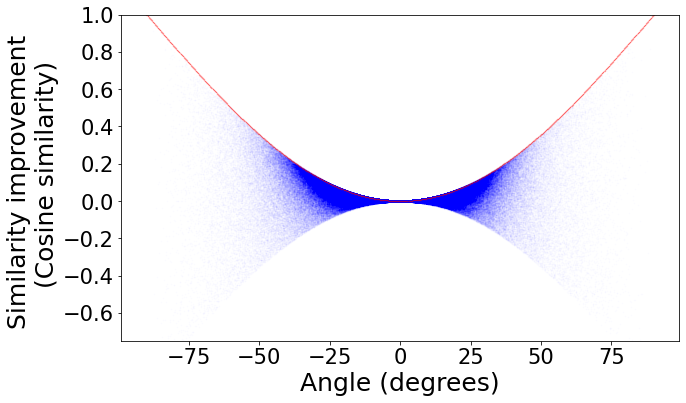

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

#fig = plt.figure()
#ax1 = fig.add_subplot(111)

plt.scatter(sine, improvement, s=0.3, c='b', marker="o", label='zadaca', alpha=0.01)  #plt.scatter(sine, improvement, s=0.3, c='b', marker="o", label='zadaca', alpha=0.01)
plt.xlabel('Angle (degrees)', fontsize=25)
plt.ylabel('Similarity improvement \n (Cosine similarity)', fontsize=25)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

#Highlight bins
sine_flattened = np.array(sine.reshape(len(sine)*len(sine[0])*len(sine[0,0]),))
bin_map=np.linspace(-90,90,1000)
bin_points = 1-np.abs(np.cos(bin_map/180*3.1416))
plt.scatter(bin_map, bin_points, s=0.1, c='red', marker="o", label='zadaca', alpha=0.5)

plt.ylim(-0.75,1)           
#
#plt.savefig('drive/My Drive/results/U_scatter.pdf', dpi='figure')  
#plt.show()

In [ ]:
print(np.max(np.nan_to_num(sine)))
print(sine.shape)
print(improvement.shape)
print(np.sum(X_model_normalized_50, axis=3).shape)

89.19476
(50, 500, 200)
(50, 500, 200)
(50, 500, 200)


In [ ]:
index[0][50:70]

NameError: ignored

(array([7.68174634e-06, 8.23044251e-06, 2.35940369e-05, 3.34704662e-05,
        6.69409324e-05, 9.32783485e-05, 1.10288405e-04, 1.42661004e-04,
        2.04663670e-04, 2.39231529e-04, 3.00138097e-04, 3.79149052e-04,
        4.70232615e-04, 5.08093746e-04, 6.13442315e-04, 6.91907358e-04,
        8.07680758e-04, 9.08094113e-04, 9.98627025e-04, 1.17476103e-03,
        1.35692562e-03, 1.44033054e-03, 1.62743283e-03, 1.86941187e-03,
        2.04060105e-03, 2.26885865e-03, 2.55473486e-03, 2.98106628e-03,
        3.26200574e-03, 3.67352084e-03, 4.12016840e-03, 4.69464947e-03,
        5.32290725e-03, 6.31714578e-03, 7.40411406e-03, 8.45102747e-03,
        9.86556772e-03, 1.11368861e-02, 1.22935509e-02, 1.38172818e-02,
        1.52927356e-02, 1.69185158e-02, 1.83571988e-02, 1.95769411e-02,
        2.01536319e-02, 2.05053521e-02, 2.09997167e-02, 2.11978047e-02,
        2.12449884e-02, 2.02809282e-02, 1.96938241e-02, 1.90128888e-02,
        1.79072698e-02, 1.67999928e-02, 1.52279852e-02, 1.378600

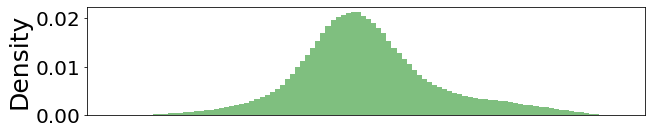

In [ ]:
sine_flattened = np.array(sine.reshape(len(sine)*len(sine[0])*len(sine[0,0]),))
improvement_flattened = np.array(improvement.reshape(len(improvement)*len(improvement[0])*len(improvement[0,0]),))
index = np.where(np.abs(improvement_flattened)>0)[0]  #No NAs
sine_flattened=sine_flattened[index]

plt.figure(figsize=(10,2))
plt.ylabel('Density', fontsize=25)
#plt.xticks(fontsize=22)
plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
plt.yticks(ticks=[0.0, 0.01, 0.02], fontsize=20)
plt.hist(sine_flattened, 100, density=True, alpha=0.5, color='g')

In [ ]:
print ( np.mean(np.nan_to_num(sine_flattened)) )
print ( np.std(np.nan_to_num(sine_flattened)) )
print(sine_flattened.shape)

-1.9363096
18.429056
(1029061,)


Text(0, 0.5, 'Saliency score')

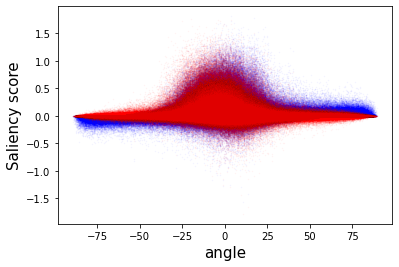

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
#ax1 = fig.add_subplot(111)

plt.scatter(sine, saliency_Peter1, s=0.5, c='b', marker="o", label='zadaca', alpha=0.03)
plt.scatter(sine, saliency_Peter3, s=0.5, c='r', marker="o", label='zadaca', alpha=0.03)
plt.xlabel('angle', fontsize=15)
plt.ylabel('Saliency score', fontsize=15)

In [ ]:
X_model_normalized_50[40,30]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.22690678],
       [0.89715743],
       [1.1522353 ],
       [2.        ],
       [1.9302994 ],
       [0.57164335],
       [2.        ],
       [2.        ],
       [1.2128849 ],
       [0.88582516],
       [0.4462769 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.53419733],
       [0.51082134],
       [0.10590982],
       [1.0077599 ],
       [1.9808763 ],
       [1.9834484 ],
       [1.982154  ],
       [2.        ],
       [0.3597176 ],
       [1.5936116 ],
       [1.8085132 ],
       [0.49755025],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [ ]:
print(sine.shape)
print(X_model_normalized_50.shape)

(50, 500, 200)
(50, 500, 200)


(-0.6, 0.8)

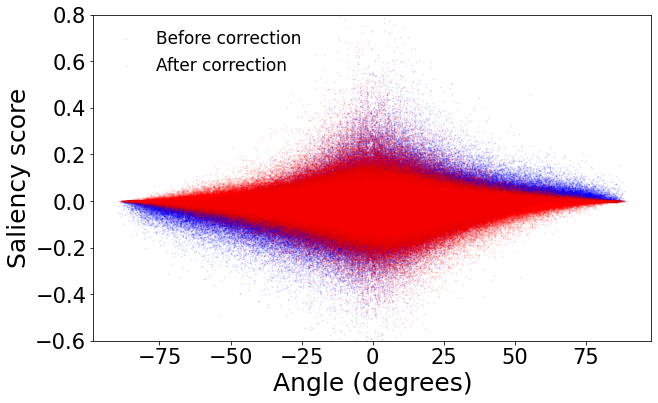

In [ ]:
# Only negative 
import matplotlib.pyplot as plt

#fig = plt.figure()
#ax1 = fig.add_subplot(111)
plt.figure(figsize=(10, 6))

#DIFFERENT DEFINITION
X_model_normalized = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   )
X_model_normalized_50 = []
for i in range (0,len(saliency_map_raw_cummulative)):
    X_model_normalized_50.append(X_model_normalized[:,:,0])   
X_model_normalized_50=np.array(X_model_normalized_50)    

#sine_negative = sine[np.logical_and(X_model_normalized_50[:,:,:,0]==0, X_model_normalized_50[:,:,:,1]==0, X_model_normalized_50[:,:,:,2]==0, X_model_normalized_50[:,:,:,3]==0)]  #No

plt.scatter(sine[X_model_normalized_50==0], saliency_Peter1[X_model_normalized_50==0], s=0.5, c='b', marker="o",  alpha=0.1, label='Before correction')
plt.scatter(sine[X_model_normalized_50==0], saliency_Peter3[X_model_normalized_50==0], s=0.5, c='r', marker="o",  alpha=0.1, label='After correction')

#plt.scatter(sine[X_model_normalized_50==0], np.zeros(len(sine[X_model_normalized_50==0])), color="black", s=0.003, marker="o")

plt.xlabel('Angle (degrees)', fontsize=25)
plt.ylabel('Saliency score', fontsize=25)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(loc='upper left', fontsize=17, frameon=False);
plt.ylim(-0.6,0.8)

(0.0, 10.0)

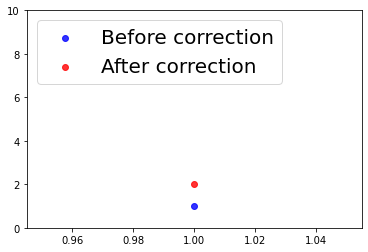

In [ ]:
plt.scatter(1, 1, s=35.5, c='b', marker="o",  alpha=0.8, label='Before correction')
plt.scatter(1, 2, s=35.5, c='r', marker="o",  alpha=0.8, label='After correction')
plt.legend(loc='upper left', fontsize=20);
plt.ylim(0,10)

In [ ]:
print(X_model_normalized_50[40,30])

[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.15187772 -0.0455118   0.23900849 -0.04161896]
 [-0.25        0.4615869  -0.17649415 -0.03509274]
 [-0.23866498  0.5174605  -0.25       -0.02879551]
 [-0.25        0.75       -0.25       -0.25      ]
 [-0.25        0.7416419  -0.25       -0.24164186]
 [-0.0944012  -0.25        0.27942526  0.06497595]
 [-0.25        0.75       -0.25       -0.25      ]
 [-0.25        0.75       -0.25

In [ ]:
(np.sum(X_model_normalized_50, axis=3)==0) [40,30]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,

In [ ]:
print(saliency_Peter1.shape)
print((X_model_normalized_50==0).shape)
print((saliency_Peter1[X_model_normalized_50==0]).shape)


(50, 500, 200)
(50, 500, 200)
(3970300,)


(-0.5, 1.2)

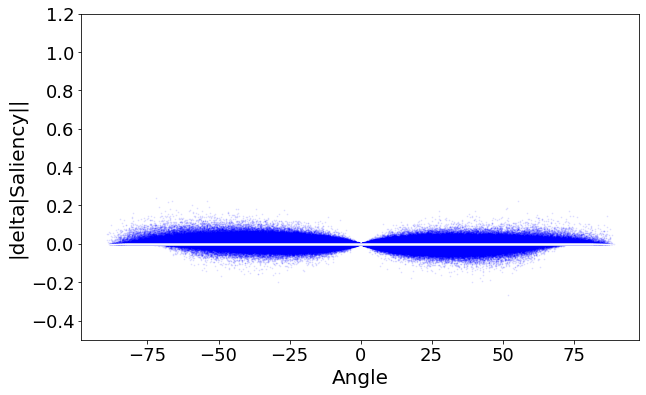

In [ ]:
# Only negative 
import matplotlib.pyplot as plt

#fig = plt.figure()
#ax1 = fig.add_subplot(111)
plt.figure(figsize=(10, 6))

sine_negative = sine[X_model_normalized_50==0]  #No

plt.scatter(sine[X_model_normalized_50==0], np.abs(saliency_Peter1[X_model_normalized_50==0])-np.abs(saliency_Peter3[X_model_normalized_50==0]), s=0.5, c='b', marker="o", label='zadaca', alpha=0.1)
#plt.scatter(sine[np.sum(X_model_normalized_50, axis=3)!=0], saliency_Peter3[np.sum(X_model_normalized_50, axis=3)>0], s=0.5, c='r', marker="o", label='zadaca', alpha=0.1)

plt.scatter(sine[X_model_normalized_50==0], np.zeros(len(sine[X_model_normalized_50==0])), color="white", s=0.01, marker="o")

plt.xlabel('Angle', fontsize=20)
plt.ylabel('|delta|Saliency||', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.5,1.2)

In [ ]:
np.average(np.abs(saliency_Peter1[np.sum(X_model_normalized_50, axis=3)==0])-np.abs(saliency_Peter3[np.sum(X_model_normalized_50, axis=3)==0]))

(-0.6, 0.8)

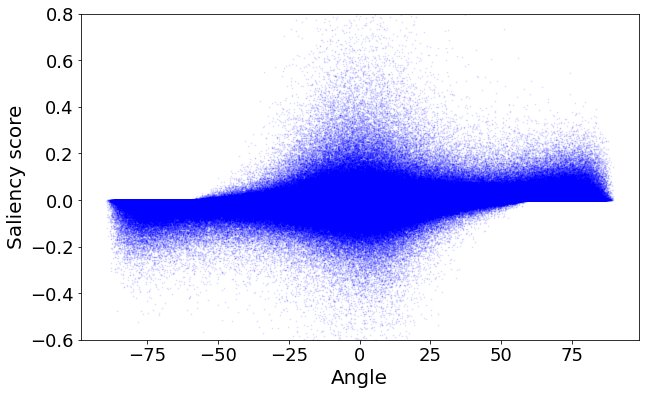

In [ ]:
# Only negative 
import matplotlib.pyplot as plt

#fig = plt.figure()
#ax1 = fig.add_subplot(111)
plt.figure(figsize=(10, 6))

sine_negative = sine[X_model_normalized_50==0]  #No

plt.scatter(sine[X_model_normalized_50==0], saliency_Peter1[X_model_normalized_50==0], s=0.5, c='b', marker="o", label='zadaca', alpha=0.1)
plt.xlabel('Angle', fontsize=20)
plt.ylabel('Saliency score', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.6,0.8)

(-0.6, 0.8)

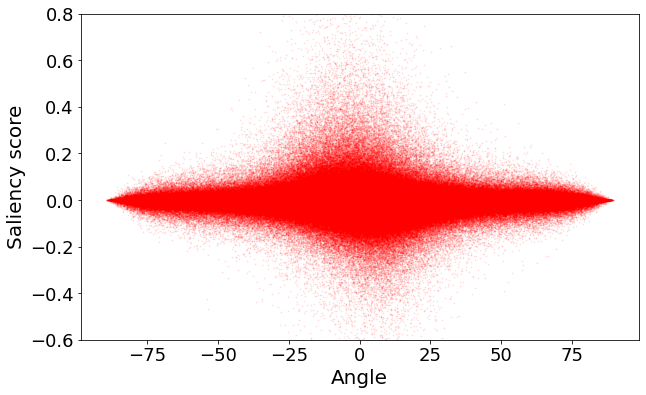

In [ ]:
# Only negative 
import matplotlib.pyplot as plt

#fig = plt.figure()
#ax1 = fig.add_subplot(111)
plt.figure(figsize=(10, 6))

sine_negative = sine[X_model_normalized_50==0]  #No

plt.scatter(sine[X_model_normalized_50==0], saliency_Peter3[X_model_normalized_50==0], s=0.5, c='r', marker="o", label='zadaca', alpha=0.1)
plt.xlabel('Angle', fontsize=20)
plt.ylabel('Saliency score', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.6,0.8)

(array([4.51380486e-06, 1.46699285e-05, 3.68157209e-05, 7.01050318e-05,
        1.12563009e-04, 1.66306209e-04, 2.17085803e-04, 2.99603798e-04,
        3.69990942e-04, 4.52651928e-04, 5.59006521e-04, 6.43640362e-04,
        7.72428158e-04, 8.97259773e-04, 1.00587320e-03, 1.16470520e-03,
        1.30392538e-03, 1.45528201e-03, 1.64429448e-03, 1.81539977e-03,
        1.99975661e-03, 2.24364792e-03, 2.44083998e-03, 2.69658100e-03,
        2.92170750e-03, 3.25163218e-03, 3.52331434e-03, 3.84914710e-03,
        4.14636179e-03, 4.53919502e-03, 4.92739276e-03, 5.39949801e-03,
        5.75553667e-03, 6.29098119e-03, 6.80696606e-03, 7.38388736e-03,
        7.96630987e-03, 8.62095333e-03, 9.31241255e-03, 1.00828634e-02,
        1.08394908e-02, 1.17136245e-02, 1.25303357e-02, 1.34117981e-02,
        1.42352862e-02, 1.50924909e-02, 1.58316232e-02, 1.64933217e-02,
        1.70732042e-02, 1.75563229e-02, 1.78425267e-02, 1.79171456e-02,
        1.79390105e-02, 1.76157065e-02, 1.72220223e-02, 1.667119

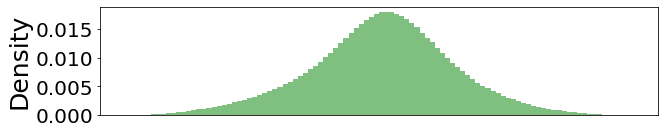

In [ ]:


plt.figure(figsize=(10,2))
plt.ylabel('Density', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
plt.hist(sine_negative, 100, density=True, alpha=0.5, color='g')

(-0.5, 1.2)

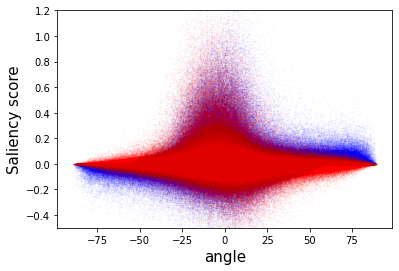

In [ ]:
#Only positive
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

sine_negative = sine[np.sum(X_model_normalized_50, axis=3)==0]  #No

ax1.scatter(sine[np.sum(X_model_normalized_50, axis=3)==0], saliency_Peter1[np.sum(X_model_normalized_50, axis=3)==0], s=0.5, c='b', marker="o", label='zadaca', alpha=0.03)
ax1.scatter(sine[np.sum(X_model_normalized_50, axis=3)==0], saliency_Peter3[np.sum(X_model_normalized_50, axis=3)==0], s=0.5, c='r', marker="o", label='zadaca', alpha=0.03)
ax1.set_xlabel('angle', fontsize=15)
ax1.set_ylabel('Saliency score', fontsize=15)
plt.ylim(-0.5,1.2)

(array([ 1.,  0.,  0.,  2.,  4.,  2.,  7.,  3., 10.,  7.,  2.,  4.,  2.,
         1.,  5.]),
 array([-32.40916  , -28.318073 , -24.226986 , -20.135899 , -16.044811 ,
        -11.953725 ,  -7.8626375,  -3.7715502,   0.3195371,   4.4106245,
          8.501712 ,  12.592799 ,  16.683886 ,  20.774973 ,  24.86606  ,
         28.957148 ], dtype=float32),
 <a list of 1 Patch objects>)

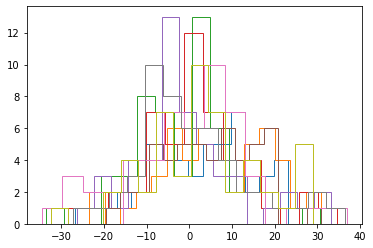

In [ ]:
plt.hist(sine[:,55,55],15,  histtype='step', stacked=True, fill=False)
plt.hist(sine[:,55,56],15,  histtype='step', stacked=True, fill=False)
plt.hist(sine[:,155,166],15,  histtype='step', stacked=True, fill=False)
plt.hist(sine[:,255,166],15,  histtype='step', stacked=True, fill=False)
plt.hist(sine[:,75,16],15,  histtype='step', stacked=True, fill=False)
plt.hist(sine[:,125,106],15,  histtype='step', stacked=True, fill=False)
plt.hist(sine[:,125,105],15,  histtype='step', stacked=True, fill=False)
plt.hist(sine[:,124,150],15,  histtype='step', stacked=True, fill=False)
plt.hist(sine[:,122,101],15,  histtype='step', stacked=True, fill=False)

In [ ]:
print(np.average(np.abs(sine_mu)))
print(np.average(np.abs(sine)))

2.1749268
11.161204


In [ ]:
print(X_model_normalized[55])

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         

In [ ]:
!pip install logomaker 

     |████████████████████████████████| 11.8MB 1.8MB/s 


In [ ]:
print(attr_score1.shape)
print(saliency_Peter1.shape)
print(np.expand_dims(saliency_Peter3, 3).shape)
print(((np.expand_dims(saliency_Peter1,3)*X_50)[49]).shape)
print(sine.shape)
print(X_model_normalized.shape)

(500, 200, 4)
(50, 500, 200)
(50, 500, 200, 1)
(500, 200, 4)
(50, 500, 200)
(500, 200, 4)


In [ ]:
'''X_50=[]
for i in range (0,len(saliency_map_raw_cummulative)):
    X_50.append(X)   
X_50=np.array(X_50)  

sequence3=(np.expand_dims(saliency_Peter1,3)*X_50)[49]
sine_dimensionsadapted=np.expand_dims(sine,3)[49]

from matplotlib.ticker import FormatStrFormatter

import logomaker 
s=13 #Pick a sequence 42


# PLOT for p=0 parameter (default classical saliency)
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = sequence3[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig = plt.gcf()


# PLOT for p=-0.333 parameter 
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = attr_score3[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig = plt.gcf()

# PLOT ground truth
N, L, A = sine_dimensionsadapted.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('K'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = (sine_dimensionsadapted)[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()


# PLOT ground truth
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGU'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = X_model_normalized[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig = plt.gcf()

In [ ]:
print(saliency_map_raw.shape)
print(X_model.shape)

(500, 200, 4)
(500, 4, 200)


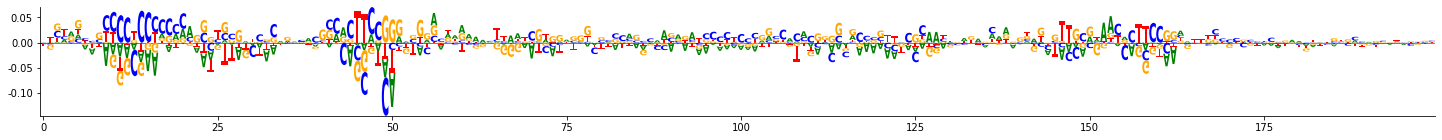

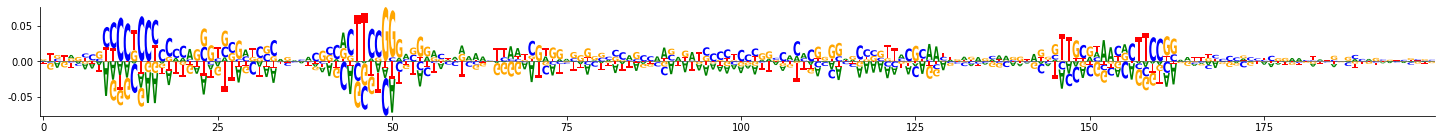

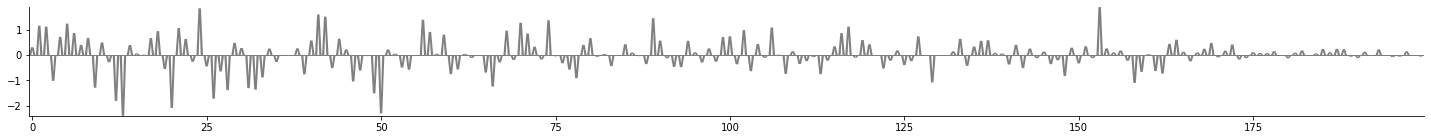

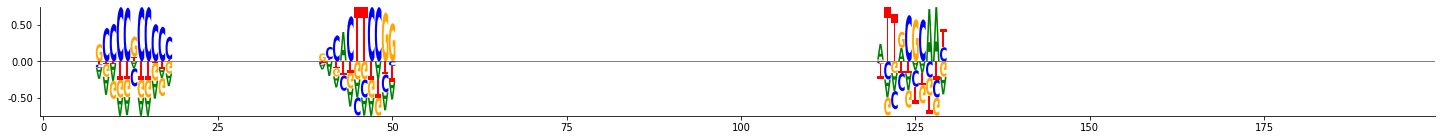

In [ ]:
saliency_map_raw
saliency_map_raw_CORRECTED = np.array(saliency_map_raw) - 0.25 * np.sum(saliency_map_raw, axis=2, keepdims=True) 

s=9 #Pick a sequence 42
run_=2

X_50=[]
for i in range (0,len(saliency_map_raw_cummulative)):
    X_50.append(X)   
X_50=np.array(X_50)  

sine_dimensionsadapted=np.expand_dims(sine,3)[run_] * np.sqrt(np.sum(np.square(saliency_map_raw),axis=2,keepdims=True))

from matplotlib.ticker import FormatStrFormatter

import logomaker 

# PLOT for p=0 parameter (default classical saliency)
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig = plt.gcf()


# PLOT for p=-0.333 parameter 
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw_CORRECTED[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig = plt.gcf()

# PLOT ground truth
N, L, A = sine_dimensionsadapted.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('∧'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = (sine_dimensionsadapted)[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    fig = plt.gcf()


# PLOT ground truth
N, L, A = attr_score1.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = np.swapaxes(X_model-0.25, 1,2)[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig = plt.gcf()

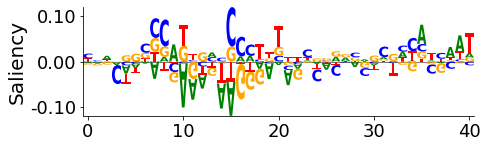

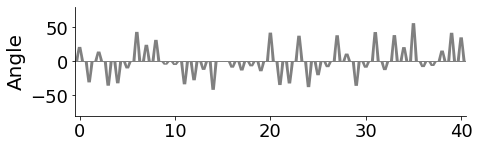

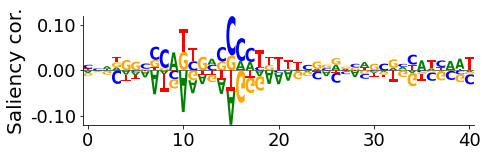

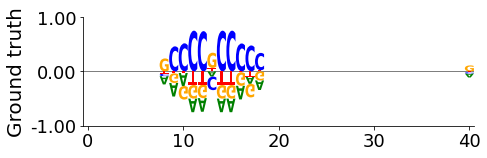

In [ ]:
saliency_map_raw
saliency_map_raw_CORRECTED = np.array(saliency_map_raw) - 0.25 * np.sum(saliency_map_raw, axis=2, keepdims=True) 

s=9 #Pick a sequence 42
run_=49

X_50=[]
for i in range (0,len(saliency_map_raw_cummulative)):
    X_50.append(X)   
X_50=np.array(X_50)  

sine_dimensionsadapted=np.expand_dims(sine,3)[run_] # np.sin(np.expand_dims(sine,3)/180*3.1416)[run_] * np.sqrt(np.sum(np.square(saliency_map_raw),axis=2,keepdims=True))
sine_dimensionsadapted2=np.expand_dims(sine,3)[run_]

from matplotlib.ticker import FormatStrFormatter

import logomaker 


#CUT
b1=0
b2=41
sine_dimensionsadapted_CUT=sine_dimensionsadapted[:,b1:b2]
sine_dimensionsadapted2_CUT=sine_dimensionsadapted2[:,b1:b2]
#X_model_CUT=X_model[:,b1:b2]
saliency_map_raw_CUT=saliency_map_raw[:,b1:b2]
saliency_map_raw_CORRECTED_CUT=saliency_map_raw_CORRECTED[:,b1:b2]



# PLOT for p=0 parameter (default classical saliency)
N, L, A = saliency_map_raw_CUT.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw_CUT[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.7,0.7))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.figure.set_size_inches(7, 2)
    ax.set_ylabel('Saliency', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)
    fig = plt.gcf()

# PLOT angle
N, L, A = sine_dimensionsadapted_CUT.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('∧'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = (sine_dimensionsadapted_CUT)[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    plt.ylim((-80,80)) 
    ax.figure.set_size_inches(7, 2)
    ax.set_ylabel('Angle', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)    
    fig = plt.gcf()


'''# PLOT angle
N, L, A = sine_dimensionsadapted2_CUT.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('∧'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = (sine_dimensionsadapted2_CUT)[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.05,0.05)) 
    ax.figure.set_size_inches(7, 2)
    #ax.set_ylabel('Angle x L2', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)    
    fig = plt.gcf()'''


# PLOT for p=-0.333 parameter 
N, L, A = saliency_map_raw_CUT.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = saliency_map_raw_CORRECTED_CUT[i][l,a]

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    #plt.ylim((-0.7,0.7)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.figure.set_size_inches(7, 2)
    ax.set_ylabel('Saliency cor.', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)    
    fig = plt.gcf()



# PLOT ground truth
N, L, A = saliency_map_raw_CUT.shape
for i in range(s,s+1):   #for i in range(len(X)):
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGT'), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = (np.swapaxes(X_model-0.25, 1,2)[:,b1:b2])[i][l,a] #(np.swapaxes(X_model, 1,2)*X)[i][l,a] 

    logomaker.Logo(counts_df, figsize=(25,2))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.yaxis.set_ticks_position('none')
    #ax.xaxis.set_ticks_position('none')
    #plt.xticks([])
    #plt.yticks([])
    plt.ylim((-1.00,1.00)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.figure.set_size_inches(7, 2)
    ax.set_ylabel('Ground truth', fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)    
    fig = plt.gcf()

In [ ]:
#### COUNT LARGE ANGLES

sine_batch = sine #[49]
XX=np.sum(X_model_normalized,axis=2)



#count lare angles
large_angle = 30
count_large_angles30 = np.zeros((len(sine),len(sine[0])))
for z in range (len(sine)):
    for i in range (len(sine[0])):
        count=0
        for j in range (len(sine[0,0])):
            if(np.abs(sine[z,i,j])>large_angle): count+=1  
        count_large_angles30[z,i]=count
count_large_angles30=np.array(count_large_angles30.reshape(len(count_large_angles30)*len(count_large_angles30[0]),))  
count_large_angles30=100* count_large_angles30/len(sine[0,0])

#count lare angles
large_angle = 45
count_large_angles45 = np.zeros((len(sine),len(sine[0])))
for z in range (len(sine)):
    for i in range (len(sine[0])):
        count=0
        for j in range (len(sine[0,0])):
            if(np.abs(sine[z,i,j])>large_angle): count+=1  
        count_large_angles45[z,i]=count
count_large_angles45=np.array(count_large_angles45.reshape(len(count_large_angles45)*len(count_large_angles45[0]),))  
count_large_angles45=100* count_large_angles45/len(sine[0,0])

#count lare angles
large_angle = 60
count_large_angles60 = np.zeros((len(sine),len(sine[0])))
for z in range (len(sine)):
    for i in range (len(sine[0])):
        count=0
        for j in range (len(sine[0,0])):
            if(np.abs(sine[z,i,j])>large_angle): count+=1  
        count_large_angles60[z,i]=count
count_large_angles60=np.array(count_large_angles60.reshape(len(count_large_angles60)*len(count_large_angles60[0]),))  
count_large_angles60=100* count_large_angles60/len(sine[0,0])

# sum |angles|
#sum_angles = np.zeros(len(sine_batch))
#for i in range (len(sine_batch)):
#   for j in range (0,200):
#       if(True):  sum_angles[i]+= np.abs(sine_batch[i,j])


In [ ]:
print(count_large_angles30.shape)
sine[20,103]. astype(int)

(25000,)


array([-24, -17, -12,  -9,   0,   1, -23,  67,  49,  18,  23,  11,  46,
       -16, -20, -11,   1, -33,  35,   0,  -1,  34, -29, -22,  11,  10,
        -9,  13,   1, -17, -28,  -8,  25,  22, -42,  45,  15,  -7,   7,
        43,  14, -43, -12,  20,  35,  32, -12, -17, -14,  -2,   2, -26,
       -20, -29, -25,  56, -39,  65,  12,  28,  -4, -17,   0, -27,   4,
       -50,  34,  -3,  15,  34,  14, -49,  34,  30,  67,  16, -35, -18,
       -11,  33,  10,  44,   4,  17,  20,  14, -17, -24,  15,   5,  -2,
        56,  47,  40,   3,   5, -39,  31,  16,  32,  18,  -1,  65,  -1,
         2, -20, -13,   7,   3,  -2, -17,  16,  -4,  18,  55,  23,  -6,
        28,  14,  24,  24, -21,  25,  45,  41, -21,  42,  48,   3,  34,
        45,  40,   0, -28,  45, -39,  20,  11,  -6, -20, -21,  -3,  10,
         5,  -3,   2,  17,  17,  52,   8,  28,  55,  71, -12,   0,   6,
         1,   5, -43,   9,  42,  13,  -7,  -3,  17,  36, -14, -33, -23,
        -1,  22,  -3, -39, -30,  -3,  18,  50, -45,  19,  19,  1

(-2.0, 50.0)

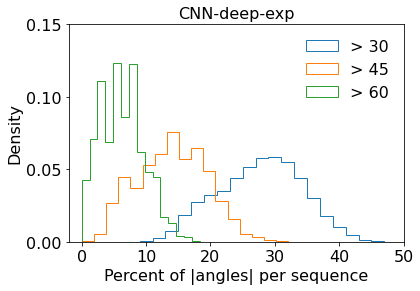

In [ ]:
#plt.figure(figsize=(10,2))
plt.hist(count_large_angles30,20,  histtype='step', stacked=True, fill=False, label = '> 30', density=True)
plt.hist(count_large_angles45,18,  histtype='step', stacked=True, fill=False, label = '> 45', density=True)
plt.hist(count_large_angles60,18,  histtype='step', stacked=True, fill=False, label = '> 60', density=True)

plt.ylabel('Density', fontsize=16)
plt.xlabel('Percent of |angles| per sequence', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([0, 0.05, 0.10, 0.15], fontsize=16)
plt.legend(loc='upper right', fontsize=16, frameon=False);
plt.title("CNN-deep-exp", fontsize=16, loc='center', pad=None)
plt.xlim(-2,50)

In [ ]:
'''plt.figure(figsize=(10,2))
plt.ylabel('Density', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
#plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
sine_flattened = np.array(sine.reshape(len(sine)*len(sine[0])*len(sine[0,0]),))
plt.hist(sine_flattened, 100, density=True, alpha=0.5, color='g')

In [ ]:
print(np.average(count_large_angles60))
print(np.average(count_large_angles45))
print(sine.shape)

30.5453
75.3339
(50, 500, 200)


In [ ]:
print(np.argmax(count_large_angles))
print(np.argmax(sum_angles))

NEW FULL SALIENCY (4 partial derivatives!!!)

In [ ]:
#New similarity measure

###  Angle histograms


######################################################################## Generate attribution maps
import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain

def Scalar_product(attr_score_copy, X_model_normalized_copy):
	scalar_product = np.average ( np.sum(np.sum(np.multiply(attr_score_copy , X_model_normalized_copy), axis=2), axis=1)/(   np.sqrt(np.sum(np.sum(np.multiply(attr_score_copy,attr_score_copy), axis=2), axis=1) )  * np.sqrt(np.sum(np.sum(np.multiply(X_model_normalized_copy,X_model_normalized_copy), axis=2), axis=1) ) )  )
	return scalar_product

saliencySCAL_print=[]
integratedSCAL_print=[]
mutagenesisSCAL_print=[]
saliency1AUROC_AUPR_print=[]
saliency3AUROC_AUPR_print=[]
integrated1AUROC_AUPR_print=[]
integrated3AUROC_AUPR_print=[]
mutagenesisAUROC_print=[]
mutagenesisAUPR_print=[]
attr_score1_cumulative = []
attr_score3_cumulative = []
saliency_map_raw_cummulative = []
fuzziness = []
L2L2 = []

#------------------------------------------------------------------------

num_trials = 50
model_names = ['cnn-dist'] #['cnn-dist', 'cnn-local']
activations = ['relu']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'   #6
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   


AAA = np.zeros(X.shape)
CCC = np.zeros(X.shape)
GGG = np.zeros(X.shape)
TTT = np.zeros(X.shape)
for ii in range (0, len(X)):
    for jj in range (0, len(X[0])):
        AAA[ii][jj][0]=1
        CCC[ii][jj][1]=1
        GGG[ii][jj][2]=1
        TTT[ii][jj][3]=1


#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            # interpretability performance with saliency maps
            saliency_scores.append(saliency(model, X, class_index=0, layer=-1))
            # interpretability performance with integrated gradients
            integrated_scores.append(integrated_grad(model, X, class_index=0, layer=-1,  num_background=10, num_steps=20,  reference='shuffle')) 


############ CORRECTION PART , Comparison of attribution maps

            #### Normalized ground truth used for Cosine metric only. (Mapped to interval [0,1]).
            X_model_normalized =   np.swapaxes(X_model, 1,2) -0.25
            #X_model_normalized = ( np.log2(4) + np.sum(np.swapaxes(X_model, 1,2)*np.log2(np.swapaxes(X_model, 1,2)+1e-10),axis=2, keepdims=True)   ) * X  

            #Raw saliency scores.  
            saliency_map_raw = np.array(saliency_scores) [trial]
            #Raw integrated gradient scores
            integrated_map_raw = np.array(integrated_scores) [trial]


            #################### New saliency, 4 derivatives
            attr_score1 = saliency_map_raw 
            attr_score3 = saliency_map_raw - 0.25 * np.sum(saliency_map_raw,axis=2, keepdims=True)

            #################### New integrated gradients, 4 derivatives 
            attr_score1_integrated = integrated_map_raw
            attr_score3_integrated = integrated_map_raw -0.25 * np.sum(integrated_map_raw, axis=2, keepdims=True) 


            saliency_map_raw_cummulative.append(saliency_map_raw)
            
            print ('-----Saliency cosine:')
            print (Scalar_product(attr_score1, X_model_normalized))  # Default (p=0)
            print (Scalar_product(attr_score3, X_model_normalized)) 
            print ('-----IG cosine:')
            print (Scalar_product(attr_score1_integrated, X_model_normalized))  # Default (p=0)
            print (Scalar_product(attr_score3_integrated, X_model_normalized))             

            saliencySCAL_print.append([Scalar_product(attr_score1, X_model_normalized), Scalar_product(attr_score3, X_model_normalized)]) 
            integratedSCAL_print.append([Scalar_product(attr_score1_integrated, X_model_normalized), Scalar_product(attr_score3_integrated, X_model_normalized)])


model: cnn-dist_relu_0
-----Saliency cosine:
0.3411957
0.35480705
-----IG cosine:
0.3845869
0.40116906
model: cnn-dist_relu_1
-----Saliency cosine:
0.3474932
0.36044094
-----IG cosine:
0.3901331
0.40125284
model: cnn-dist_relu_2
-----Saliency cosine:
0.43595088
0.45654693
-----IG cosine:
0.5052357
0.5273313
model: cnn-dist_relu_3
-----Saliency cosine:
0.3961435
0.41458637
-----IG cosine:
0.5255148
0.5471507
model: cnn-dist_relu_4
-----Saliency cosine:
0.2285209
0.23786451
-----IG cosine:
0.055576112
0.05763937
model: cnn-dist_relu_5
-----Saliency cosine:
0.4312749
0.44733113
-----IG cosine:
0.6057476
0.6284255
model: cnn-dist_relu_6
-----Saliency cosine:
0.38072473
0.39568627
-----IG cosine:
0.29131863
0.30078942
model: cnn-dist_relu_7
-----Saliency cosine:
0.36407465
0.38163215
-----IG cosine:
0.48711583
0.5094876
model: cnn-dist_relu_8
-----Saliency cosine:
0.51711595
0.5402944
-----IG cosine:
0.56127906
0.5847967
model: cnn-dist_relu_9
-----Saliency cosine:
0.37424922
0.38854203
---

In [ ]:
'''#SAL_COSINE={}
#SAL_COSINE_c={}
IG_COSINE={}
IG_COSINE_c={}'''

#SAL_COSINE[model_name + "_" + activation]=np.array(saliencySCAL_print)[:,0]
#SAL_COSINE_c[model_name + "_" + activation]= np.array(saliencySCAL_print)[:,1]

IG_COSINE[model_name + "_" + activation]=np.array(integratedSCAL_print)[:,0]
IG_COSINE_c[model_name + "_" + activation]= np.array(integratedSCAL_print)[:,1]

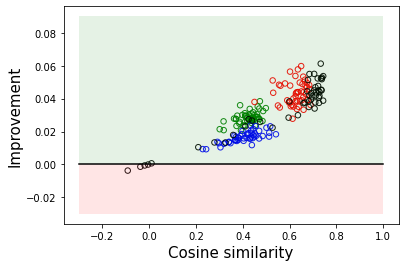

In [ ]:
# Saliency Cosine
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.add_patch( patches.Rectangle( (-0.3, 0), 1.3, 0.09, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (-0.3, 0), 1.3, -0.03, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-local_relu'], SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'
mean1a=np.average(SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-local_exponential'], SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)
mean1b=np.average(SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-dist_relu'], SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)
mean1c=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu']))

#---------------------
#Cosine
ax1.scatter( SAL_COSINE['cnn-dist_exponential'], SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)
mean1d=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential']))


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(-0.3, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Cosine similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
plt.savefig('drive/My Drive/results/Cosine_Saliency.pdf')  
plt.show()

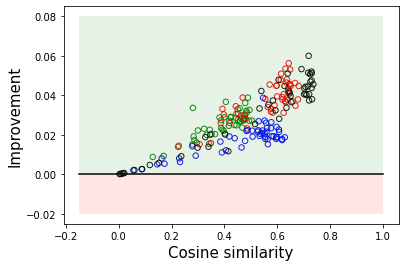

In [ ]:
# IG Cosine 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)


ax1.add_patch( patches.Rectangle( (-0.15, 0), 1.15, 0.08, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (-0.15, 0), 1.15, -0.02, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-local_relu'], IG_COSINE_c['cnn-local_relu']-IG_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'
mean1a=np.average(IG_COSINE_c['cnn-local_relu']-IG_COSINE['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-local_exponential'], IG_COSINE_c['cnn-local_exponential']-IG_COSINE['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)
mean1b=np.average(IG_COSINE_c['cnn-local_exponential']-IG_COSINE['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-dist_relu'], IG_COSINE_c['cnn-dist_relu']-IG_COSINE['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)
mean1c=np.average(np.nan_to_num(IG_COSINE_c['cnn-dist_relu']-IG_COSINE['cnn-dist_relu']))

#---------------------
#Cosine
ax1.scatter( IG_COSINE['cnn-dist_exponential'], IG_COSINE_c['cnn-dist_exponential']-IG_COSINE['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)
mean1d=np.average(np.nan_to_num(IG_COSINE_c['cnn-dist_exponential']-IG_COSINE['cnn-dist_exponential']))


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(-0.15, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Cosine similarity', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
plt.savefig('drive/My Drive/results/Cosine_IG.pdf')  
plt.show()

PERFORMANCE ACROSS MODELS vs INTERPRETABILITY

In [ ]:
#Performance across models

import os
import numpy as np
from six.moves import cPickle
from tensorflow import keras
import helper
# from tfomics import utils, explain

performance_map={}
#------------------------------------------------------------------------

num_trials = 50
model_names = ['cnn-local', 'cnn-dist'] #['cnn-dist', 'cnn-local']
activations = ['relu','exponential']  # ['relu', 'exponential', 'sigmoid', 'tanh', 'softplus', 'linear', 'elu']


results_path = os.path.join('drive/My Drive/results', 'task3')
params_path = os.path.join(results_path, 'model_params')
save_path = make_directory(results_path, 'scores')

#------------------------------------------------------------------------

# load data
data_path = 'drive/My Drive/data/synthetic_code_dataset.h5'
data = load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = load_synthetic_models(data_path, dataset='test')
true_index = np.where(y_test[:,0] == 1)[0]
X = x_test[true_index][:500]  
X_model = test_model[true_index][:500]   

#------------------------------------------------------------------------

for model_name in model_names:
    for activation in activations:
        
        saliency_scores = []
        mut_scores = []
        integrated_scores = []
        shap_scores = []
        performance_list=[]
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = load_model(model_name, activation=activation)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            # compile model
            compile_model(model)

            # load model
            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)

            #Save performance
            predictions = model.predict(x_test)                
            mean_vals, std_vals = calculate_metrics(y_test, predictions, 'binary')
            performance_list.append(mean_vals[1])
        performance_map[model_name + "_" + activation] =performance_list         


model: cnn-local_relu_0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


model: cnn-local_relu_1
model: cnn-local_relu_2
model: cnn-local_relu_3
model: cnn-local_relu_4
model: cnn-local_relu_5
model: cnn-local_relu_6
model: cnn-local_relu_7
model: cnn-local_relu_8
model: cnn-local_relu_9
model: cnn-local_relu_10
model: cnn-local_relu_11
model: cnn-local_relu_12
model: cnn-local_relu_13
model: cnn-local_relu_14
model: cnn-local_relu_15
model: cnn-local_relu_16
model: cnn-local_relu_17
model: cnn-local_relu_18
model: cnn-local_relu_19
model: cnn-local_relu_20
model: cnn-local_relu_21
model: cnn-local_relu_22
model: cnn-local_relu_23
model: cnn-local_relu_24
model: cnn-local_relu_25
model: cnn-local_relu_26
model: cnn-local_relu_27
model: cnn-local_relu_28
model: cnn-local_relu_29
model: cnn-local_relu_30
model: cnn-local_relu_31
model: cnn-local_relu_32
model: cnn-local_relu_33
model: cnn-local_relu_34
model: cnn-local_relu_35
model: cnn-local_relu_36
model: cnn-local_relu_37
model: cnn-local_relu_38
model: cnn-local_relu_39
model: cnn-local_relu_40
model: cn

In [ ]:
'''# 4-Saliency cosine 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, 0.09, facecolor = 'green', fill=True , alpha=0.1 ) )
ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, -0.03, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_relu'], SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'
mean1a=np.average(SAL_COSINE_c['cnn-local_relu']-SAL_COSINE['cnn-local_relu'])

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_exponential'], SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)
mean1b=np.average(SAL_COSINE_c['cnn-local_exponential']-SAL_COSINE['cnn-local_exponential'])

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_relu'], SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)
mean1c=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_relu']-SAL_COSINE['cnn-dist_relu']))

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_exponential'], SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)
mean1d=np.average(np.nan_to_num(SAL_COSINE_c['cnn-dist_exponential']-SAL_COSINE['cnn-dist_exponential']))


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.92, 1.0, 100)
ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Performance', fontsize=15)
plt.ylabel('Improvement', fontsize=15)
#plt.savefig('drive/My Drive/results/SaliencyImprovement_Performance.pdf')  
plt.show()

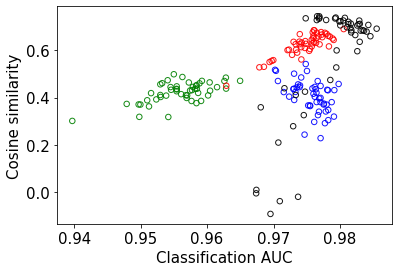

In [ ]:
# 4-Saliency Cosine
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(np.array(saliencySCAL_print)[:,0], np.array(saliencySCAL_print)[:,1], s=30, c='g', marker="o", label='COSINE', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,0], np.array(saliency3AUROC_AUPR_print)[:,0], s=30, c='b', marker="o", label='AUROC', alpha=0.7)
#ax1.scatter(np.array(saliency1AUROC_AUPR_print)[:,1], np.array(saliency3AUROC_AUPR_print)[:,1], s=30, c='r', marker="o", label='AUPR', alpha=0.7)

#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, 0.9, facecolor = 'green', fill=True , alpha=0.1 ) )
#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, -0.3, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_relu'], SAL_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_exponential'], SAL_COSINE['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_relu'], SAL_COSINE['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_exponential'], SAL_COSINE['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.92, 1.0, 100)
#ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Classification AUC', fontsize=15)
plt.ylabel('Cosine similarity', fontsize=15)
plt.savefig('drive/My Drive/results/Performance_VS_SaliencyCosine.pdf')  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

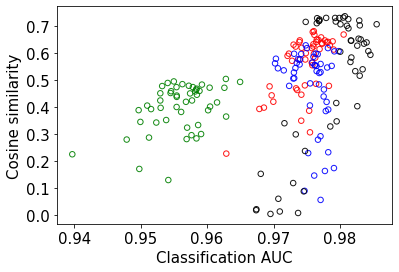

In [ ]:
# IG Cosine
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig = plt.figure()
ax1 = fig.add_subplot(111)


#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, 0.9, facecolor = 'green', fill=True , alpha=0.1 ) )
#ax1.add_patch( patches.Rectangle( (0.92, 0), 0.08, -0.3, facecolor = 'red', fill=True , alpha=0.1 ) )

alpha=0.9
#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_relu'], IG_COSINE['cnn-local_relu'], s=30, edgecolors='g',facecolors='none', marker="o", alpha=alpha) #label='COSINE'

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-local_exponential'], IG_COSINE['cnn-local_exponential'], s=30, edgecolors='r',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_relu'], IG_COSINE['cnn-dist_relu'], s=30, edgecolors='b',facecolors='none', marker="o", alpha=alpha)

#---------------------
#Cosine
ax1.scatter( performance_map['cnn-dist_exponential'], IG_COSINE['cnn-dist_exponential'], s=30, edgecolors='black',facecolors='none', marker="o", alpha=alpha)


#ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
#ax1.set_aspect('equal')
#ax1.set_xlim(-0.03,0.19)
#ax1.set_ylim(-0.05,0.09)


x__ = np.linspace(0.92, 1.0, 100)
#ax1.plot(x__, x__*0, c="black");


#plt.legend(loc='lower right');
plt.xlabel('Classification AUC', fontsize=15)
plt.ylabel('Cosine similarity', fontsize=15)
plt.savefig('drive/My Drive/results/Performance_VS_IGCosine.pdf')  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


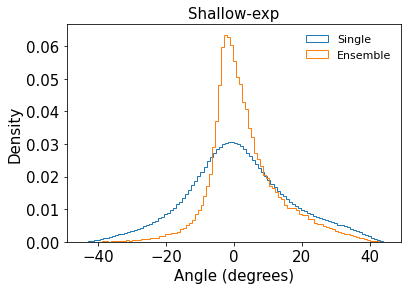

In [ ]:
import matplotlib.pyplot as plt

saliency_map_raw_AVERAGE = np.average(np.array(saliency_map_raw_cummulative)  , axis = 0)

orthogonal_residual=(saliency_map_raw_AVERAGE[:,:,0]+saliency_map_raw_AVERAGE[:,:,1]+saliency_map_raw_AVERAGE[:,:,2]+saliency_map_raw_AVERAGE[:,:,3]) 
L2 = np.sqrt(np.sum(np.square(saliency_map_raw_AVERAGE[:,:,:]), axis=2))
sine = 1/2 * orthogonal_residual /L2 
sine = np.arcsin(sine) * 180 /( 2* 3.1416) 

sine_average =np.array(sine.reshape(len(sine)*len(sine[0]),))

saliency_map_raw_cummulative=np.array(saliency_map_raw_cummulative)

orthogonal_residual=(saliency_map_raw_cummulative[:,:,:,0]+saliency_map_raw_cummulative[:,:,:,1]+saliency_map_raw_cummulative[:,:,:,2]+saliency_map_raw_cummulative[:,:,:,3]) 
L2 = np.sqrt(np.sum(np.square(saliency_map_raw_cummulative[:,:,:,:]), axis=3))
sine = 1/2 * orthogonal_residual /L2 
sine = np.arcsin(sine) * 180 /( 2* 3.1416) 

sine =np.array(sine.reshape(len(sine)*len(sine[0])*len(sine[0,0]),))
plt.xlabel('Angle (degrees)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.hist(sine, 100, density=True, histtype='step', label = 'Single')
plt.hist(sine_average, 100, density=True, histtype='step', label = 'Ensemble')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Shallow-exp',fontsize=15)
#plt.hist(count_large_angles30,20,  histtype='step', stacked=True, fill=False, label = '> 30', density=True)
#plt.hist(count_large_angles45,18,  histtype='step', stacked=True, fill=False, label = '> 45', density=True)
#plt.hist(count_large_angles60,18,  histtype='step', stacked=True, fill=False, label = '> 60', density=True)
plt.legend(loc='upper right', fontsize=11, frameon=False);
#plt.yscale('log')

In [ ]:
print(x_train.shape)

(14000, 200, 4)
